In [1]:
from __future__ import annotations

from typing import Union, Optional

import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('/home/inca/default.mplstyle')

from astropy import units as u
from astropy import constants as const

from scipy.optimize import curve_fit
import emcee
import corner

import LWphotorates as lwrad

In [2]:
class Spectrum:

    def __init__(
            self: Spectrum,
            frequency: Optional[Union[np.array, u.Quantity]] = None,
            energy: Optional[Union[np.array, u.Quantity]] = None,
            wavelength: Optional[Union[np.array, u.Quantity]] = None,
            intensity_frequency: Optional[Union[np.array, u.Quantity]] = None,
            intensity_wavelength: Optional[Union[np.array, u.Quantity]] = None) -> None:

        if not (frequency is not None) | (energy is not None) | (wavelength is not None):
            raise AssertionError("Provide at least one between frequency, energy and wavelength.")
        if not (intensity_frequency is not None) | (intensity_wavelength is not None):
            raise AssertionError("Provide the spectrum either in the frequency or wavelength space.")

        if frequency is not None:
            if not isinstance(frequency, u.Quantity):
                frequency *= u.Hz
            else:
                frequency = frequency.to(u.Hz)
            self.frequency = frequency
            self.wavelength = lwrad.utils.nu2lambda(self.frequency)
            self.energy = self.frequency * const.h.to(u.eV / u.Hz)
        elif energy is not None:
            if not isinstance(energy, u.Quantity):
                energy *= u.eV
            else:
                energy = energy.to(u.eV)
            self.energy = energy
            self.frequency = self.energy / const.h.to(u.eV / u.Hz)
            self.wavelength = lwrad.utils.nu2lambda(self.frequency)
        elif wavelength is not None:
            if not isinstance(wavelength, u.Quantity):
                wavelength *= u.angstrom
            else:
                wavelength = wavelength.to(u.angstrom)
            self.wavelength = wavelength
            self.frequency = lwrad.utils.lambda2nu(self.wavelength)
            self.energy = self.frequency * const.h.to(u.eV / u.Hz)

        if intensity_frequency is not None:
            monocromatic_intensity_unit = u.erg / u.s / u.Hz / u.sr / u.cm**2
            if not isinstance(intensity_frequency, u.Quantity):
                intensity_frequency *= monocromatic_intensity_unit
            else:
                intensity_frequency = intensity_frequency.to(monocromatic_intensity_unit)
            self.spectrum_frequency = intensity_frequency
            self.spectrum_wavelength = lwrad.utils.spec_nu2lambda(self.frequency, self.spectrum_frequency)
        elif intensity_wavelength is not None:
            monocromatic_intensity_unit = u.erg / u.s / u.angstrom / u.sr / u.cm**2
            if not isinstance(intensity_frequency, u.Quantity):
                intensity_wavelength *= monocromatic_intensity_unit
            else:
                intensity_wavelength = intensity_wavelength.to(monocromatic_intensity_unit)
            self.spectrum_wavelength = intensity_wavelength
            self.intensity_frequency = lwrad.utils.spec_lambda2nu(self.wavelength, self.spectrum_wavelength)


In [3]:
default_gas_density = 1e0 * u.cm**-3
default_gas_temperature = 1e2 * u.K
default_distance = np.sqrt(1. / 4. / np.pi) * u.cm
solid_angle = 4. * np.pi * u.sr
conv_fact_intensity_to_luminosity = solid_angle * u.cm**2

h2_min_gspop = 1e-5
h2_min_foscxfdiss = 1e-6

In [187]:
energy_array = np.linspace(lwrad.HM.get_reaction_min_energy(), lwrad.HM.get_ioniz_energy_hydrogen(), 10000)
flat_spectrum = Spectrum(
    energy=energy_array,
    intensity_frequency=lwrad.utils.generate_flat_spectrum(len(energy_array))
)
radiation_temperature_array = np.logspace(3.7, 5, 50) * u.K
blackbody_spectra = Spectrum(
    energy=energy_array,
    intensity_frequency=[lwrad.utils.generate_blackbody_spectrum(
        radtemp, energy_array, True, lwrad.HM.get_ioniz_energy_hydrogen()) for radtemp in radiation_temperature_array]
)
for spec in [flat_spectrum, blackbody_spectra]:
    spec.spectrum_frequency *= 1e-21
    spec.spectrum_wavelength *= 1e-21

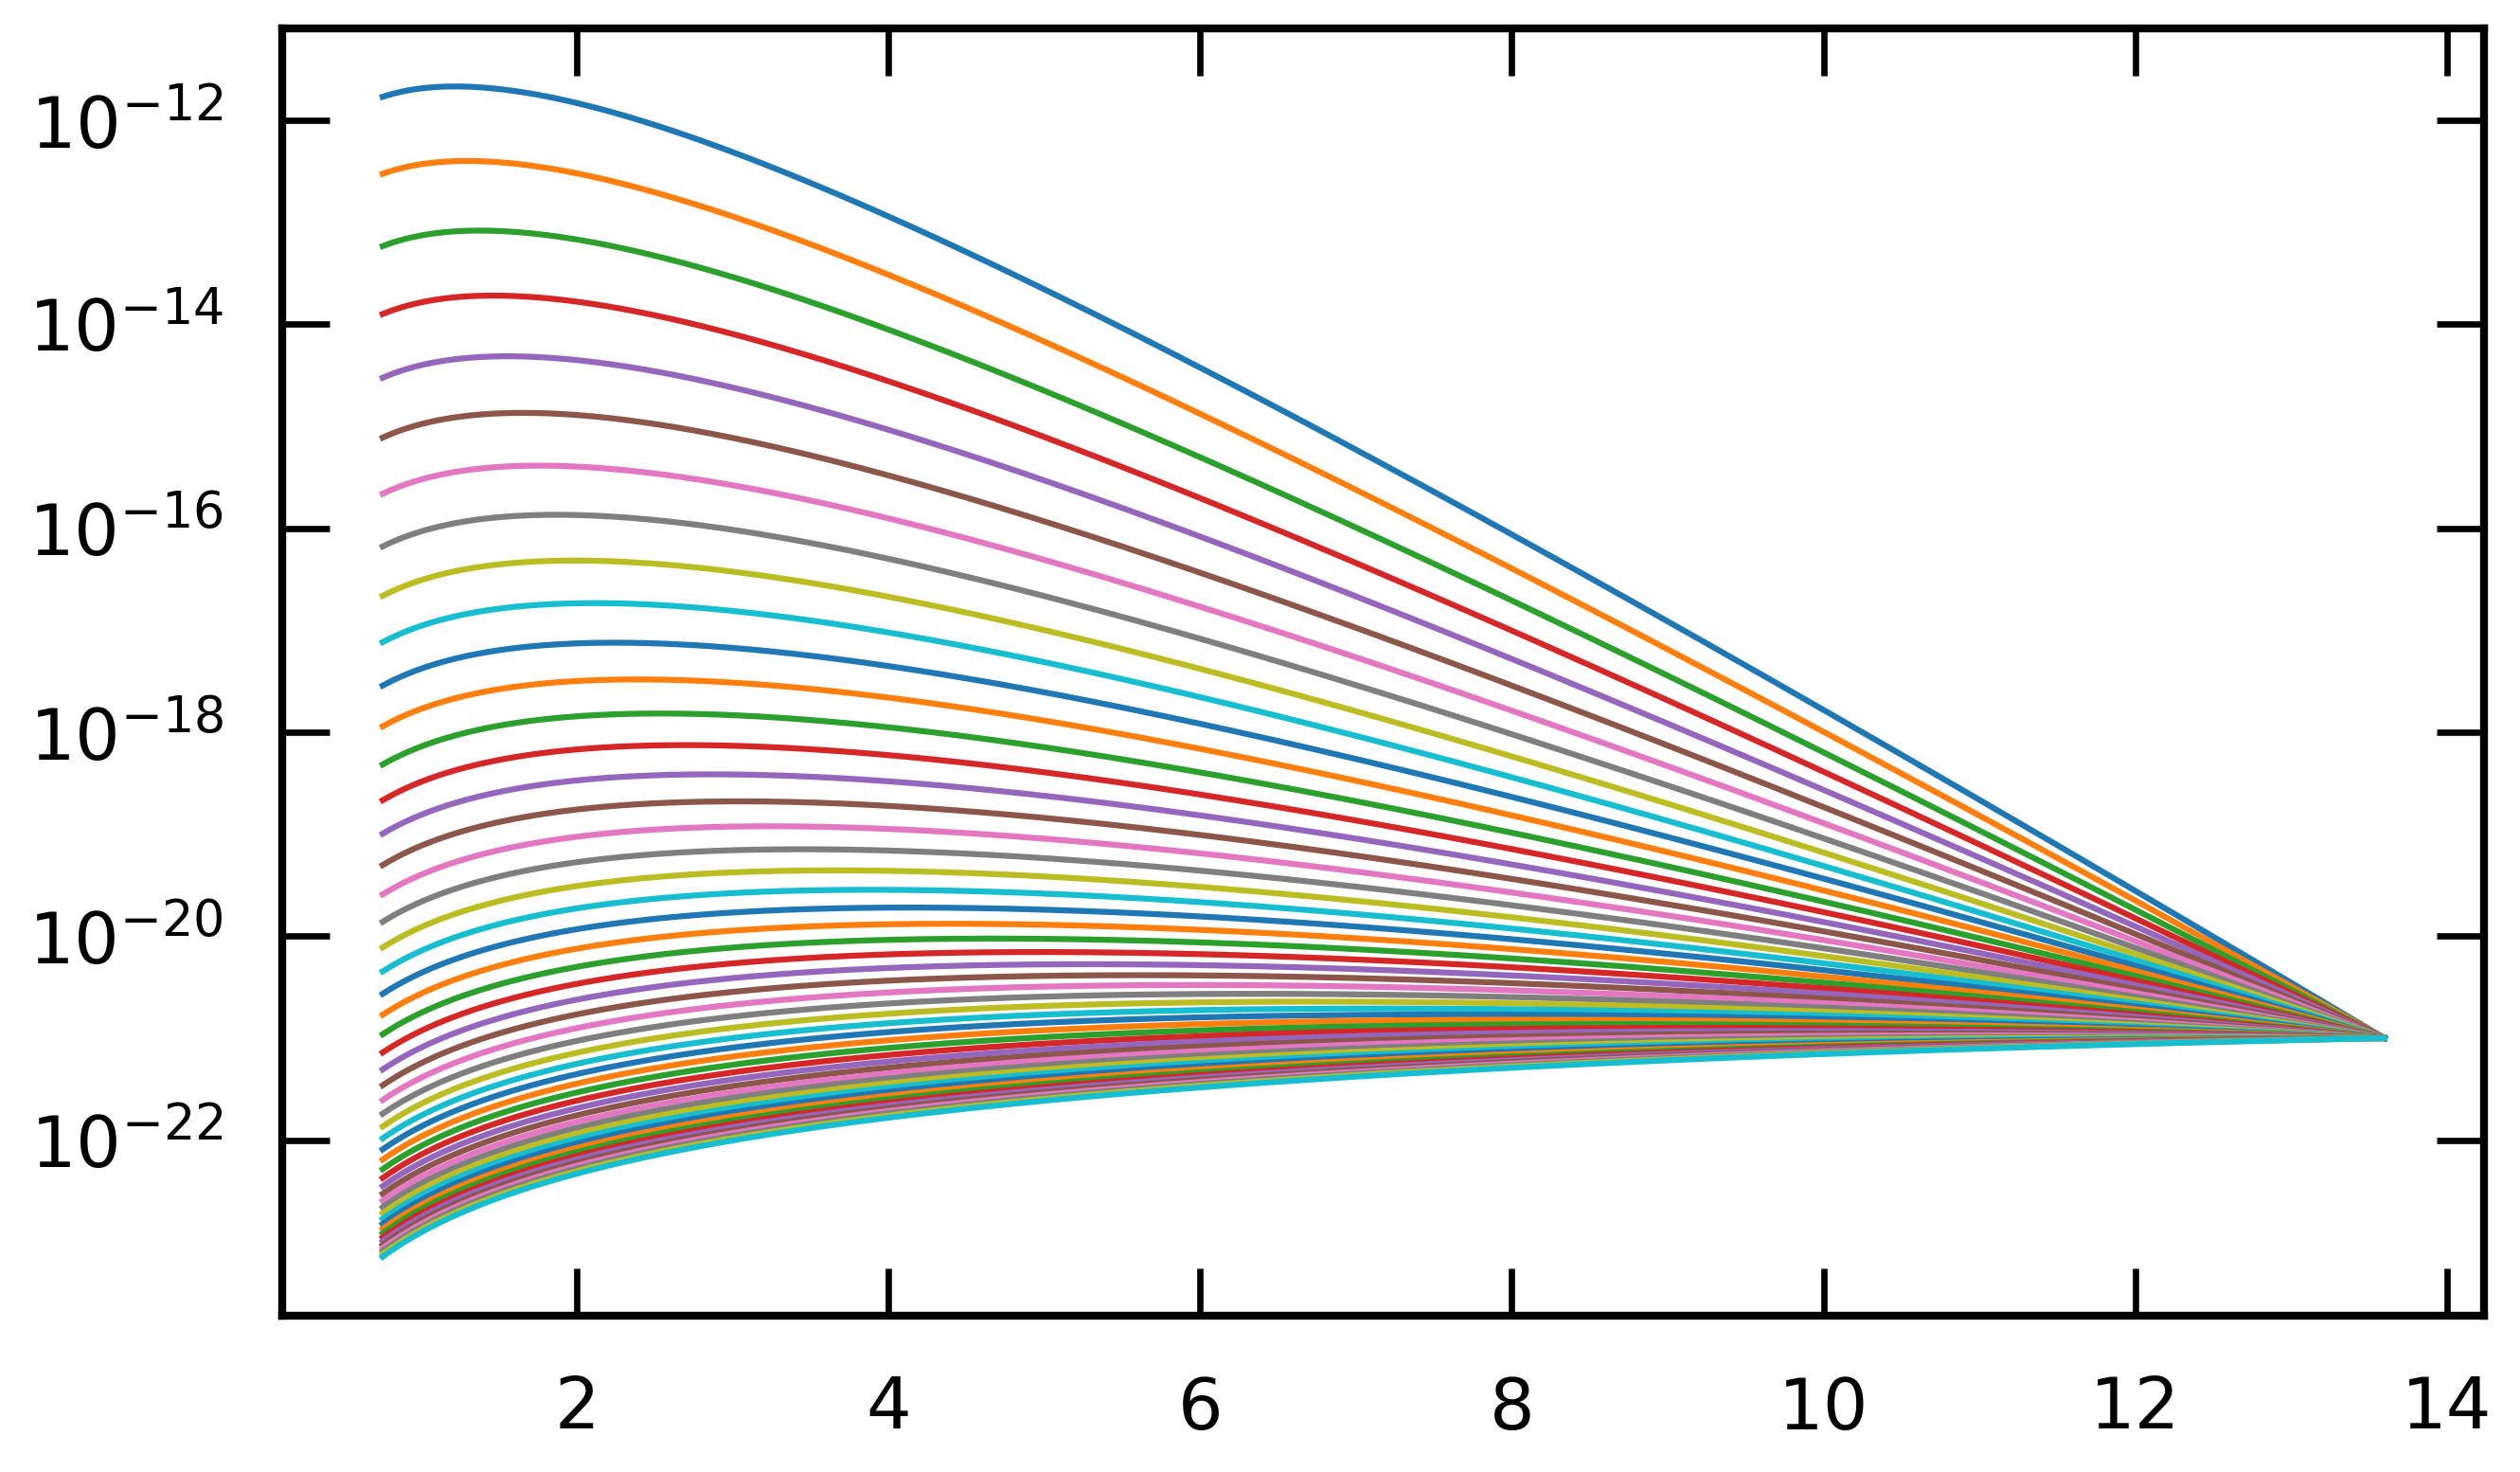

In [188]:
fig, ax = plt.subplots()
for spec in blackbody_spectra.spectrum_frequency:
    ax.plot(blackbody_spectra.energy, spec)
ax.set_yscale('log')

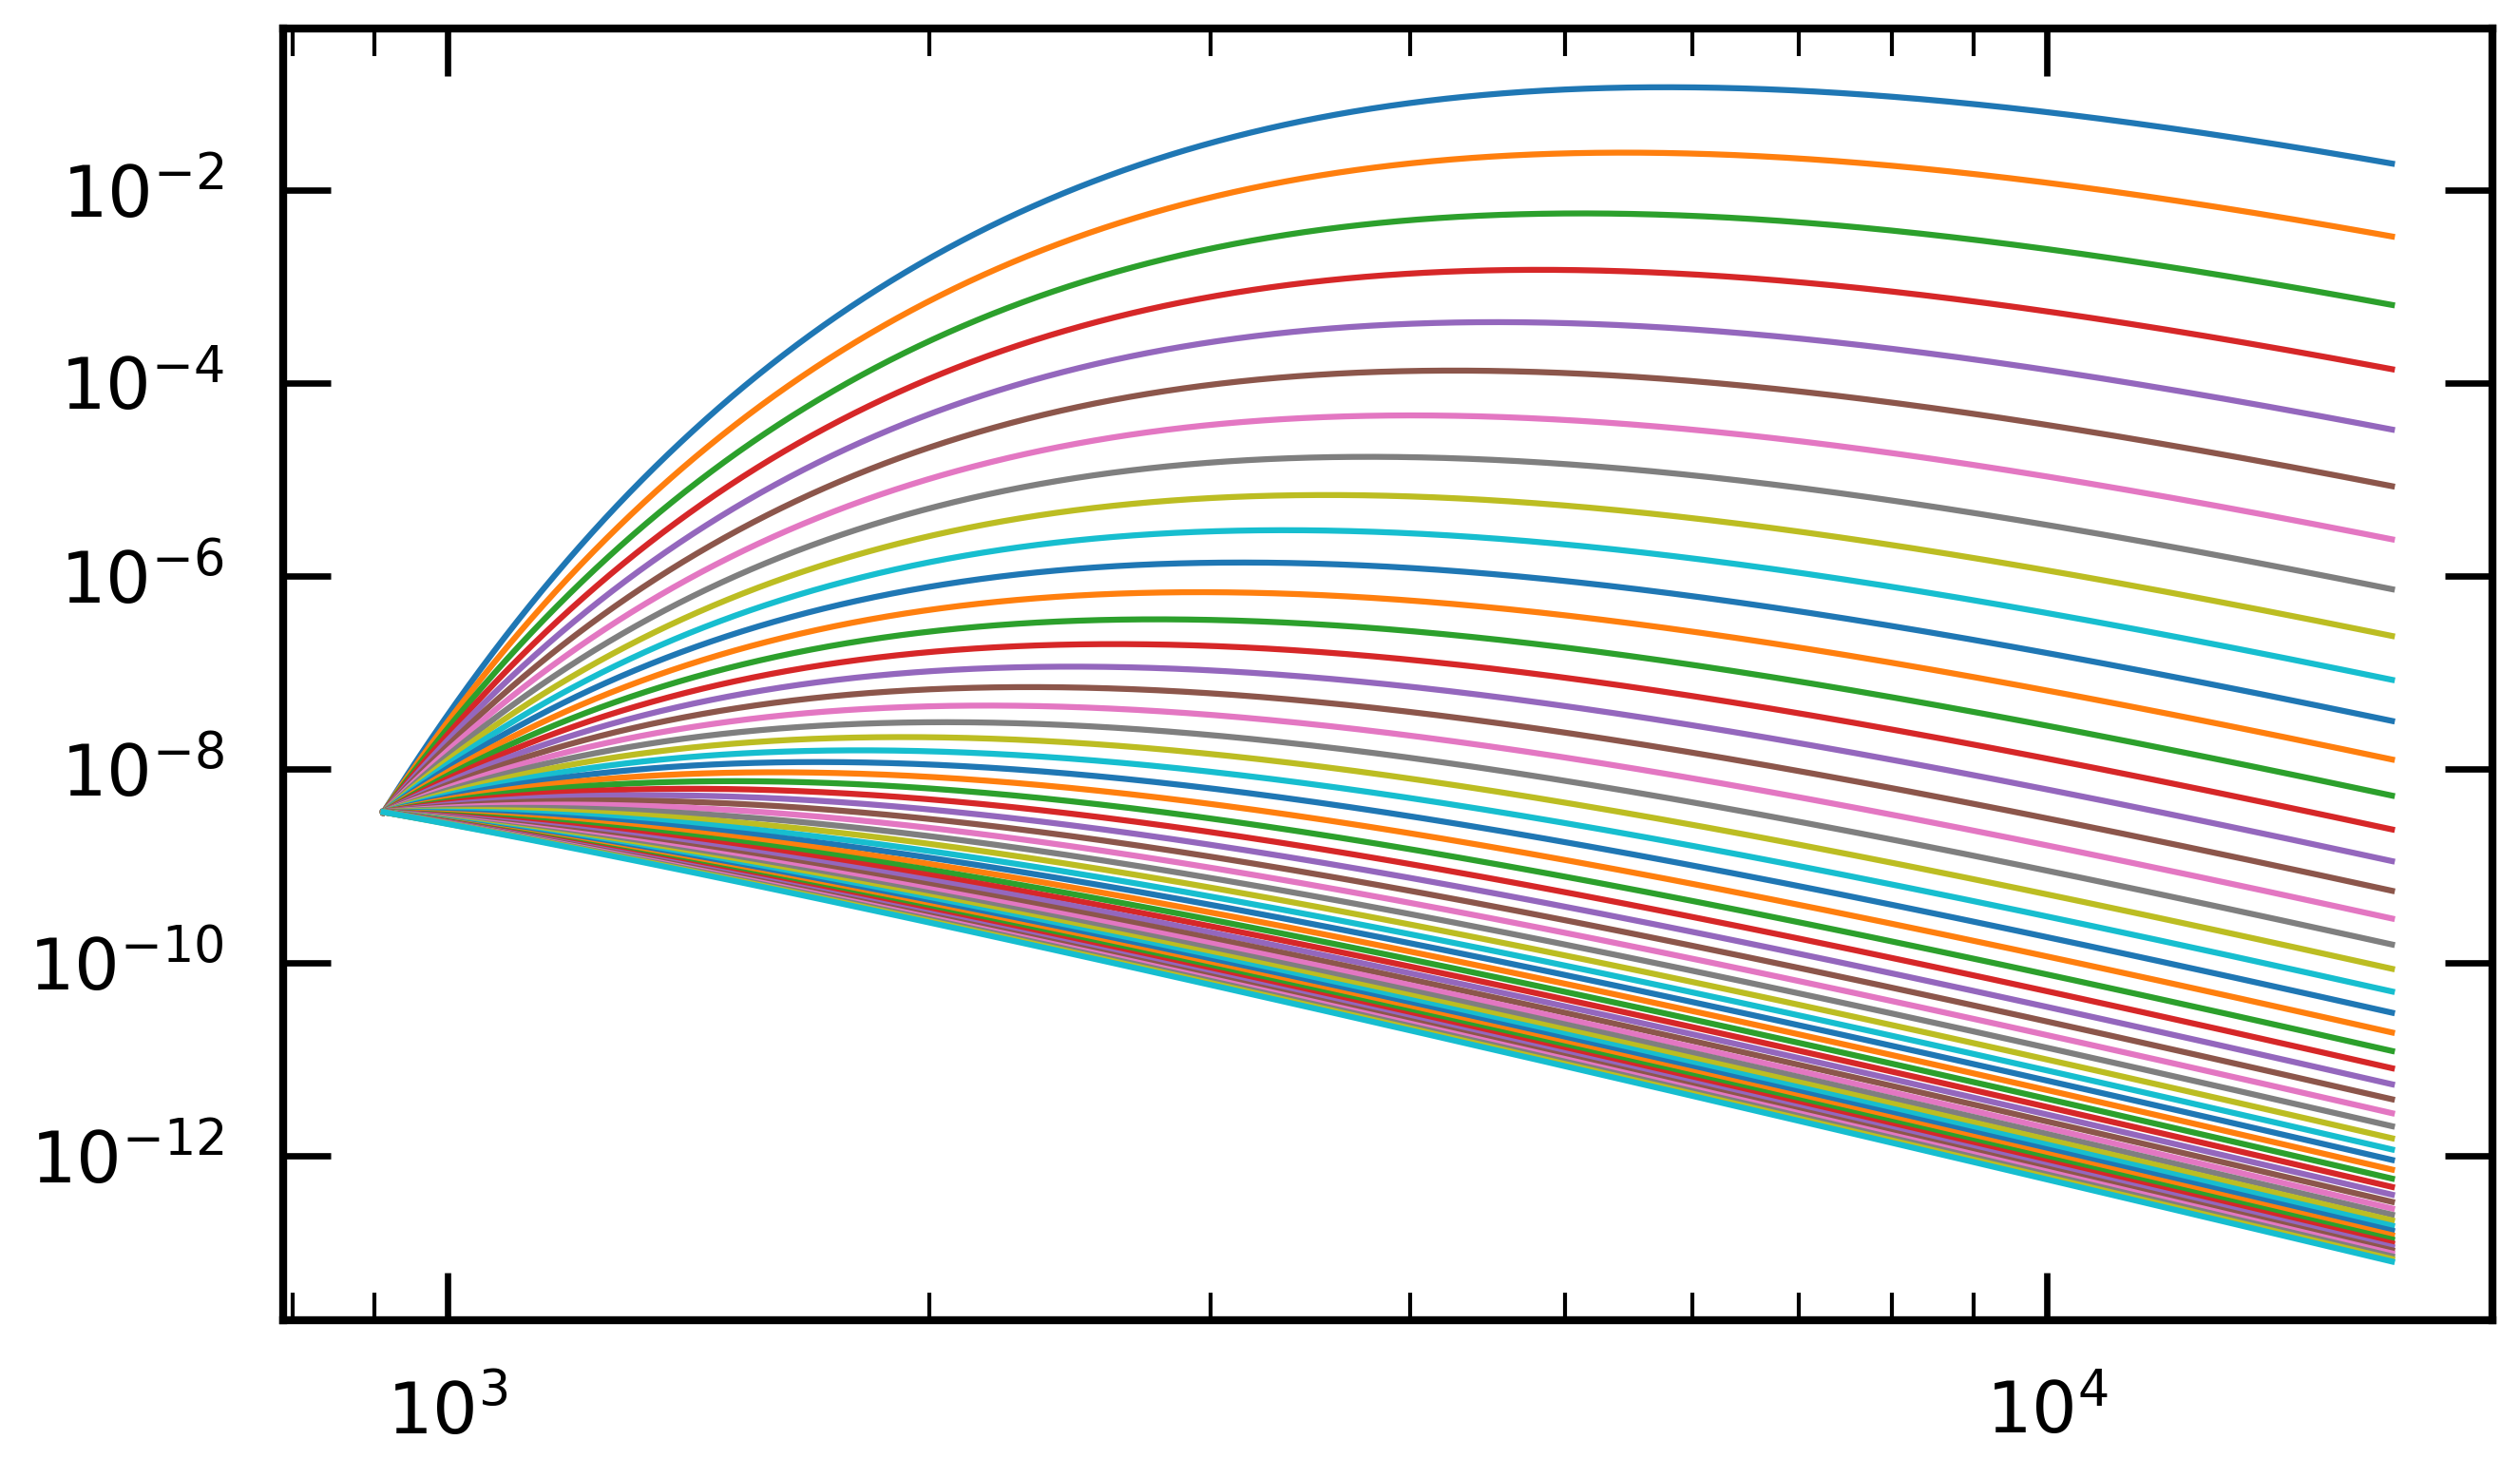

In [189]:
fig, ax = plt.subplots()
for spec in blackbody_spectra.spectrum_wavelength:
    ax.plot(blackbody_spectra.wavelength, spec)
ax.set_yscale('log')
ax.set_xscale('log')


In [190]:
h2rate_flatspec = lwrad.compute_H2_diss_rate(
    wavelength_array=flat_spectrum.wavelength,
    spectra_wl=flat_spectrum.spectrum_wavelength*conv_fact_intensity_to_luminosity,
    distance=default_distance,
    gas_density=default_gas_density,
    gas_temperature=default_gas_temperature,
    min_partition_function=h2_min_gspop,
    min_osc_strength_x_diss_fraction=h2_min_foscxfdiss)[0]

h2prate_flatspec = lwrad.compute_H2p_diss_rate(
    wavelength_array=flat_spectrum.wavelength,
    spectra_wl=flat_spectrum.spectrum_wavelength*conv_fact_intensity_to_luminosity,
    distance=default_distance,
    gas_density=default_gas_density,
    gas_temperature=default_gas_temperature,
    cross_section_reference='Z_17')[0]

hmrate_flatspec = lwrad.compute_HM_detach_rate(
    wavelength_array=flat_spectrum.wavelength,
    spectra_wl=flat_spectrum.spectrum_wavelength*conv_fact_intensity_to_luminosity,
    distance=default_distance,
    cross_section_reference='ML_17')

/home/inca/miniconda3/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/inca/miniconda3/lib/python3.8/site-packages/frigus/solvers/linear.py:48: LinAlgWarning: Ill-conditioned matrix (rcond=9.93892e-27): result may not be accurate.
  C21 = scipy.linalg.solve(A22, A21)


In [191]:
h2rate_bbspec = lwrad.compute_H2_diss_rate(
    wavelength_array=blackbody_spectra.wavelength,
    spectra_wl=blackbody_spectra.spectrum_wavelength*conv_fact_intensity_to_luminosity,
    distance=default_distance,
    gas_density=default_gas_density,
    gas_temperature=default_gas_temperature,
    min_partition_function=h2_min_gspop,
    min_osc_strength_x_diss_fraction=h2_min_foscxfdiss)[0]

h2prate_bbspec = lwrad.compute_H2p_diss_rate(
    wavelength_array=blackbody_spectra.wavelength,
    spectra_wl=blackbody_spectra.spectrum_wavelength*conv_fact_intensity_to_luminosity,
    distance=default_distance,
    gas_density=default_gas_density,
    gas_temperature=default_gas_temperature,
    cross_section_reference='Z_17')[0]

hmrate_bbspec = lwrad.compute_HM_detach_rate(
    wavelength_array=blackbody_spectra.wavelength,
    spectra_wl=blackbody_spectra.spectrum_wavelength*conv_fact_intensity_to_luminosity,
    distance=default_distance,
    cross_section_reference='ML_17')

In [192]:
input_data_for_fit = {
    'radtemp': radiation_temperature_array.value,
    'h2rate': h2rate_bbspec.value,
    'hmrate': hmrate_bbspec.value,
    'h2prate': h2prate_bbspec.value,
    'logradtemp': np.log10(radiation_temperature_array.value),
    'logh2rate': np.log10(h2rate_bbspec.value),
    'loghmrate': np.log10(hmrate_bbspec.value),
    'logh2prate': np.log10(h2prate_bbspec.value)
}

def latif_funct_h2(x, a, b, c, d):
    return (a + b * x + c * x**2)**(-1) - d

def latif_funct_hm(x, a, b, c, d):
    return (a + b * x)**(-1 / c) - d

def latif_funct_h2p(x, a, b, c, d):
    return (-1. * a + b * x)**(-1 / c) + d

def third_order_poly(x, a, b, c, d):
    return a + b * x + c * x**2 + d * x**3

def second_order_poly(x, a, b, c):
    return a + b * x + c * x**2

def alternative_function(x, a, b, c):
    return (a + b * x)**-1 - c

In [193]:
def find_initial_guess(
        input_data_for_fit: dict, rate: str, factor_for_pard: float,
        verbose: bool = True) -> np.ndarray:
    x_array = input_data_for_fit['radtemp']
    y_array = input_data_for_fit[f'log{rate}rate']
    index_temp_0 = 0
    index_temp_1 = 11
    index_temp_2 = -1

    matrix = np.array(
        [[1, x_array[index_temp_0], x_array[index_temp_0]**2],
         [1, x_array[index_temp_1], x_array[index_temp_1]**2],
         [1, x_array[index_temp_2], x_array[index_temp_2]**2]]
    )
    param_d = -1. * y_array[-1] * factor_for_pard # 1.001 (v1), 1.03 (v2), 1.01 (v3), 0.99 [DOES NOT WORK]
    column = np.array(
        [1 / (y_array[index_temp_0] + param_d),
         1 / (y_array[index_temp_1] + param_d),
         1 / (y_array[index_temp_2] + param_d)]
    )
    params = np.append(np.linalg.solve(matrix, column), param_d)

    if verbose:
        print(f'the initial guess will be: \t {params}')

    return params


def fit_with_scipy(
        input_data_for_fit: dict, rate: str,
        function_to_use: function, initial_guess: np.ndarray,
        verbose: bool = True) -> np.ndarray:

    x_array = input_data_for_fit['radtemp']
    y_array = input_data_for_fit[f'log{rate}rate']
    sigma = 1e3 / x_array**(1/3)
    abs_sigma = False

    best_fit_params, covar_matrix = curve_fit(
        f=function_to_use,
        xdata=x_array,
        ydata=y_array,
        p0=initial_guess,
        sigma=sigma,
        absolute_sigma=abs_sigma)

    if verbose:
        print(f'the best fit params are: \t {best_fit_params}')
    
    return best_fit_params


In [194]:
h2_initial_guess = find_initial_guess(input_data_for_fit, 'h2', 1.001)
h2_params = fit_with_scipy(input_data_for_fit, 'h2', latif_funct_h2, h2_initial_guess, True)

hm_initial_guess = find_initial_guess(input_data_for_fit, 'hm', 1.03)
hm_params = fit_with_scipy(input_data_for_fit, 'hm', latif_funct_h2, hm_initial_guess, True)

h2p_initial_guess = find_initial_guess(input_data_for_fit, 'h2p', 1.01)
h2p_params = fit_with_scipy(input_data_for_fit, 'h2p', latif_funct_h2, h2p_initial_guess, True)

fit_params = {
    'h2_guess': h2_initial_guess,
    'h2_scipy': h2_params,
    'hm_guess': hm_initial_guess,
    'hm_scipy': hm_params,
    'h2p_guess': h2p_initial_guess,
    'h2p_scipy': h2p_params
}

the initial guess will be: 	 [-3.13127833e-02  2.01641029e-04  6.40356776e-09  1.18928148e+01]
the best fit params are: 	 [-1.61237218e-01  2.42086225e-04  3.22217577e-09  1.18987554e+01]
the initial guess will be: 	 [-2.64121487e-02  2.42940282e-05  6.67943036e-11  1.11800959e+01]
the best fit params are: 	 [7.69237298e-04 1.57827540e-05 7.69953035e-10 1.09557720e+01]
the initial guess will be: 	 [-1.31131134e-01  7.03930689e-05  1.86930646e-10  1.15067166e+01]
the best fit params are: 	 [-6.84664318e-02  4.99511930e-05  1.88589801e-09  1.14287526e+01]


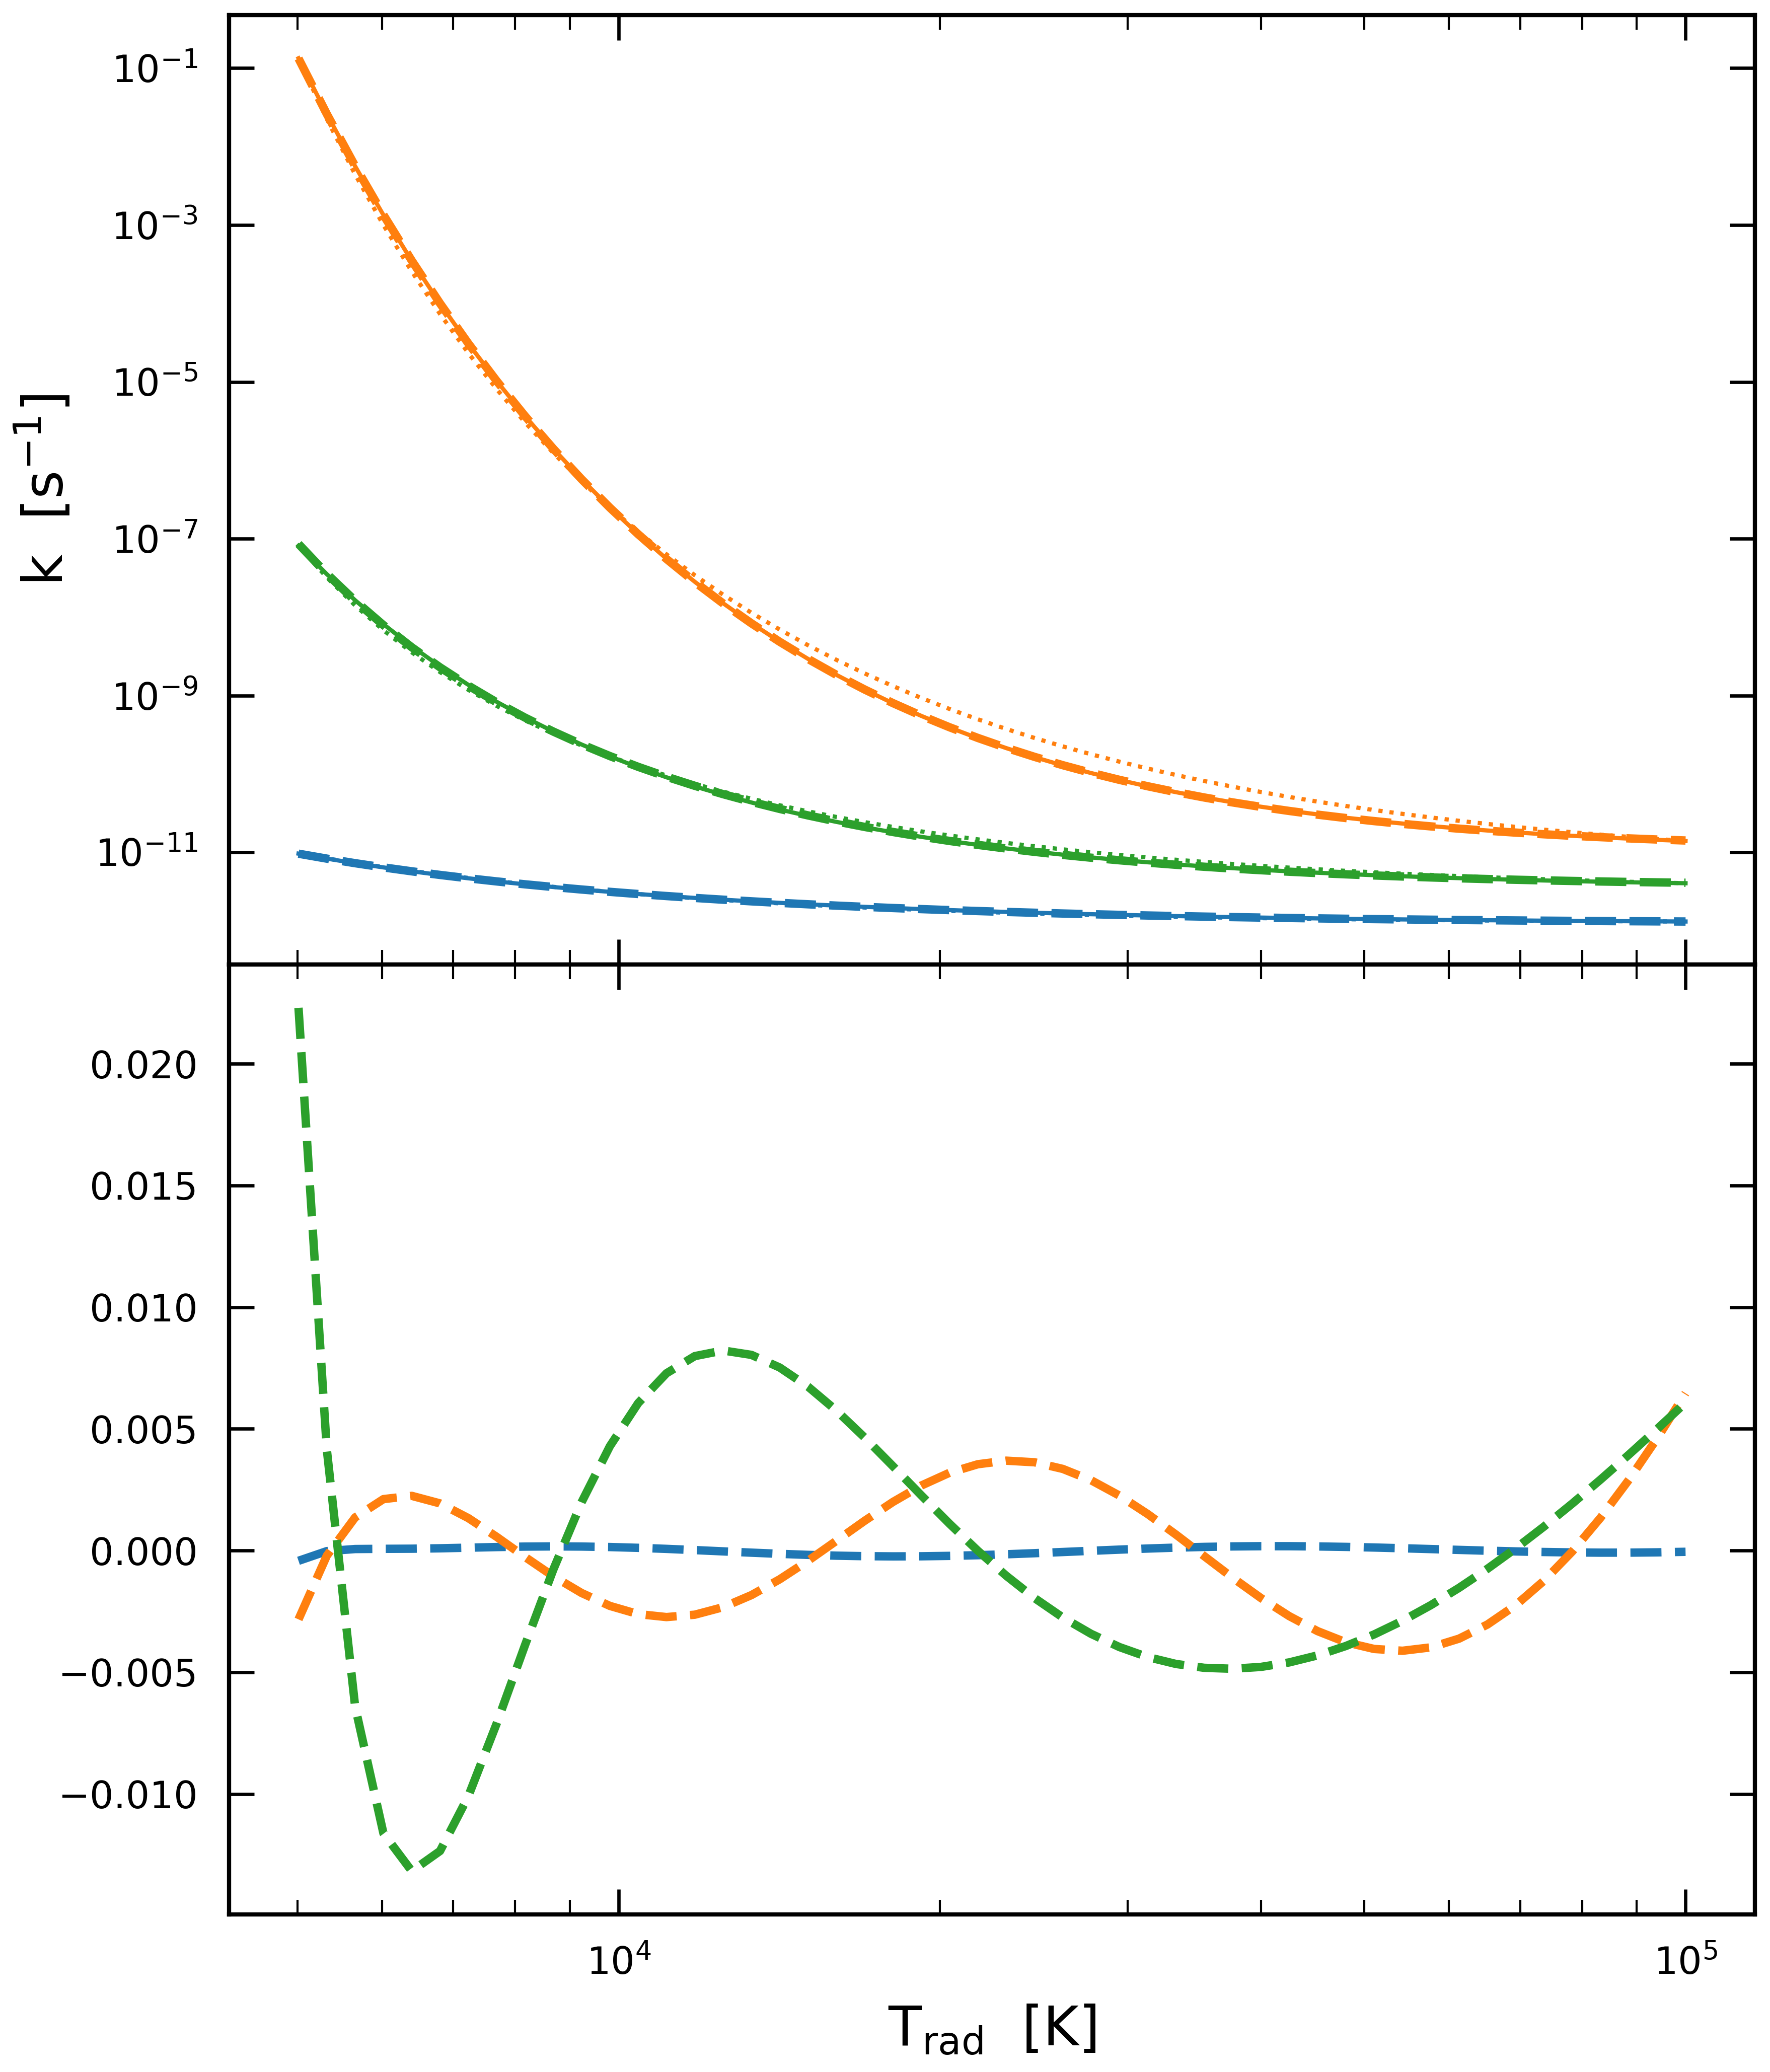

In [195]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(12, 14))
ax = axes[0]
for i, rate in enumerate(['h2', 'hm', 'h2p']):
    ax.plot(
        input_data_for_fit['radtemp'],
        input_data_for_fit[f'{rate}rate'],
        lw=2, ls='-', c=f'C{i}')
    ax.plot(
        input_data_for_fit['radtemp'],
        np.power(10., latif_funct_h2(input_data_for_fit['radtemp'], *fit_params[f'{rate}_guess'])),
        lw=2, ls=':', c=f'C{i}')
    ax.plot(
        input_data_for_fit['radtemp'],
        np.power(10., latif_funct_h2(input_data_for_fit['radtemp'], *fit_params[f'{rate}_scipy'])),
        lw=4, ls='--', c=f'C{i}')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'k  [s$^{-1}$]')

ax = axes[1]
for i, rate in enumerate(['h2', 'hm', 'h2p']):
    ax.plot(
        input_data_for_fit['radtemp'],
        latif_funct_h2(input_data_for_fit['radtemp'], *fit_params[f'{rate}_scipy']) - input_data_for_fit[f'log{rate}rate'],
        lw=4, ls='--', c=f'C{i}')
ax.set_xlabel(r'T$_\mathrm{rad}$  [K]')
plt.tight_layout()
plt.subplots_adjust(hspace=0)


In [196]:
def model(theta: np.ndarray, data_x: np.ndarray) -> np.ndarray:
    a, b, c, d = theta
    model = latif_funct_h2(data_x, a, b, c, d)
    return model

def ln_likelihood(
        theta: np.ndarray, data_x: np.ndarray, data_y: np.ndarray,
        data_yerr: np.ndarray) -> float:
    model_y = model(theta, data_x)
    return -0.5 * np.sum(((data_y - model_y) / data_yerr)**2)

def ln_prior(theta: np.ndarray, pars_bounds: np.ndarray) -> float:
    a, b, c, d = theta
    a_min, a_max, b_min, b_max, c_min, c_max, d_min, d_max = pars_bounds
    if a_min < a < a_max and b_min < b < b_max and c_min < c < c_max and d_min < d < d_max:
        return 0.0
    else:
        return -np.inf

def ln_prob(
        theta: np.ndarray,
        data_x: np.ndarray, data_y: np.ndarray, data_yerr: np.ndarray,
        pars_bounds: np.ndarray) -> float:
    lp = ln_prior(theta, pars_bounds)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_likelihood(theta, data_x, data_y, data_yerr)

def run_mcmc(
        input_data_for_fit: dict,
        rate: str,
        initial_guess: np.ndarray,
        mcmc_pars_bounds: np.ndarray,
        lnprob_funct: function) -> np.ndarray:

    n_walkers = 50
    n_iter = 10000
    n_dim = len(initial_guess)
    initial_param = [np.array(initial_guess) + 0.05 * initial_guess * np.random.randn(n_dim) for i in range(n_walkers)]

    sigma_array = 1e-2 * (5e3 / input_data_for_fit['radtemp'])**(1/4)
    data_for_mcmc_fit = (
        input_data_for_fit['radtemp'],
        input_data_for_fit[f'log{rate}rate'],
        sigma_array,
        mcmc_pars_bounds
    )

    sampler = emcee.EnsembleSampler(n_walkers, n_dim, lnprob_funct, args=data_for_mcmc_fit)

    print("Running burn-in...")
    initial_param, _, _ = sampler.run_mcmc(initial_param, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(initial_param, n_iter)

    # originally this function returned Tuple[emcee.EnsembleSampler, np.ndarray, np.ndarray, tuple]

    return sampler.flatchain

In [197]:
h2_mcmc_pars_bounds = np.array([-1, 1, -1e3, 1e3, -1e-7, 1e-7, 8, 14])
h2_mcmc_all_samples = run_mcmc(input_data_for_fit, 'h2', fit_params['h2_scipy'], h2_mcmc_pars_bounds, ln_prob)

hm_mcmc_pars_bounds = np.array([-1, 1, -1e3, 1e3, -1e-7, 1e-7, 8, 14])
hm_mcmc_all_samples = run_mcmc(input_data_for_fit, 'hm', fit_params['hm_scipy'], hm_mcmc_pars_bounds, ln_prob)

h2p_mcmc_pars_bounds = np.array([-1, 1, -1e3, 1e3, -1e-7, 1e-7, 8, 14])
h2p_mcmc_all_samples = run_mcmc(input_data_for_fit, 'h2p', fit_params['h2p_scipy'], h2p_mcmc_pars_bounds, ln_prob)

Running burn-in...
Running production...
Running burn-in...
Running production...
Running burn-in...
Running production...


In [198]:
fit_params['h2_mcmc'] = np.percentile(h2_mcmc_all_samples, 50., axis=0)
print(fit_params['h2_mcmc'])

fit_params['hm_mcmc'] = np.percentile(hm_mcmc_all_samples, 50., axis=0)
print(fit_params['hm_mcmc'])

fit_params['h2p_mcmc'] = np.percentile(h2p_mcmc_all_samples, 50., axis=0)
print(fit_params['h2p_mcmc'])

[-1.66590646e-01  2.43459320e-04  3.11986004e-09  1.18992706e+01]
[8.19506853e-04 1.57687318e-05 7.70926331e-10 1.09554919e+01]
[-6.65030047e-02  4.94127105e-05  1.92313365e-09  1.14273832e+01]


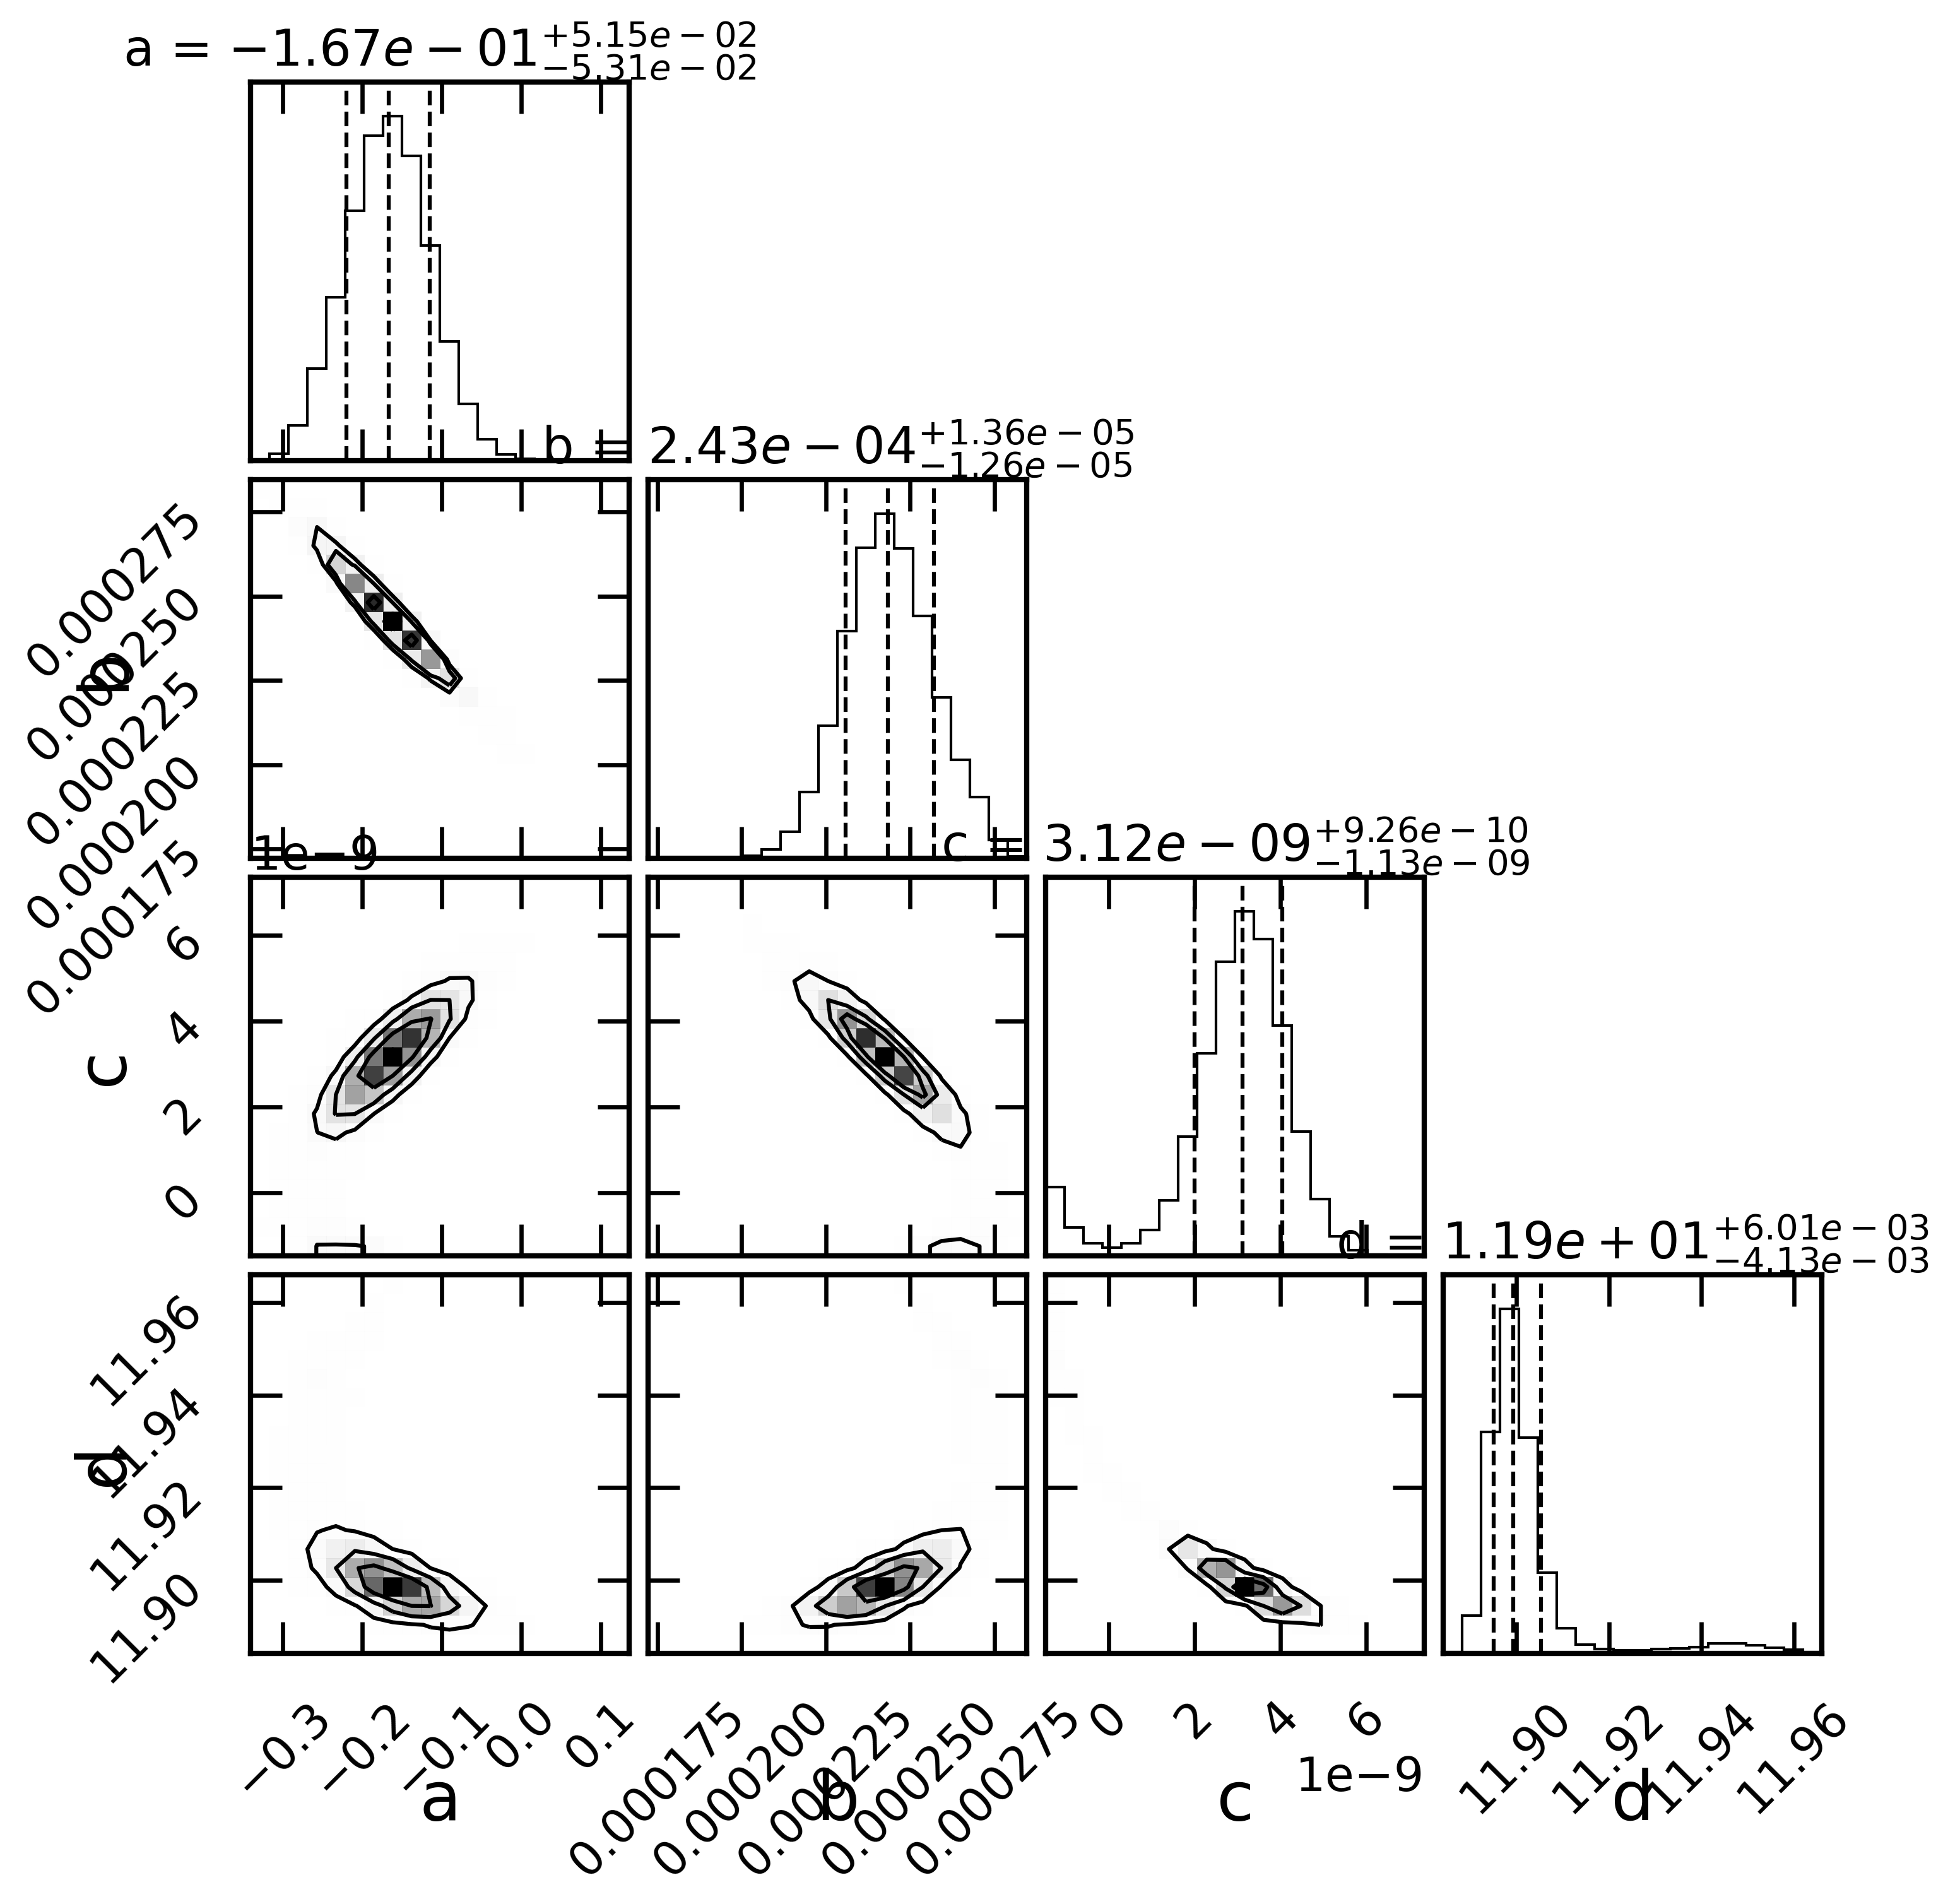

In [199]:
labels = ['a', 'b', 'c', 'd']
fig = corner.corner(
    h2_mcmc_all_samples,
    show_titles=True,
    labels=labels,
    plot_datapoints=False,
    quantiles=[0.16, 0.5, 0.84],
    title_fmt='.2e')
fig.savefig('plots/results/bbrate_fit/h2_cornerplot.png')
fig.savefig('plots/results/bbrate_fit/h2_cornerplot.pdf')

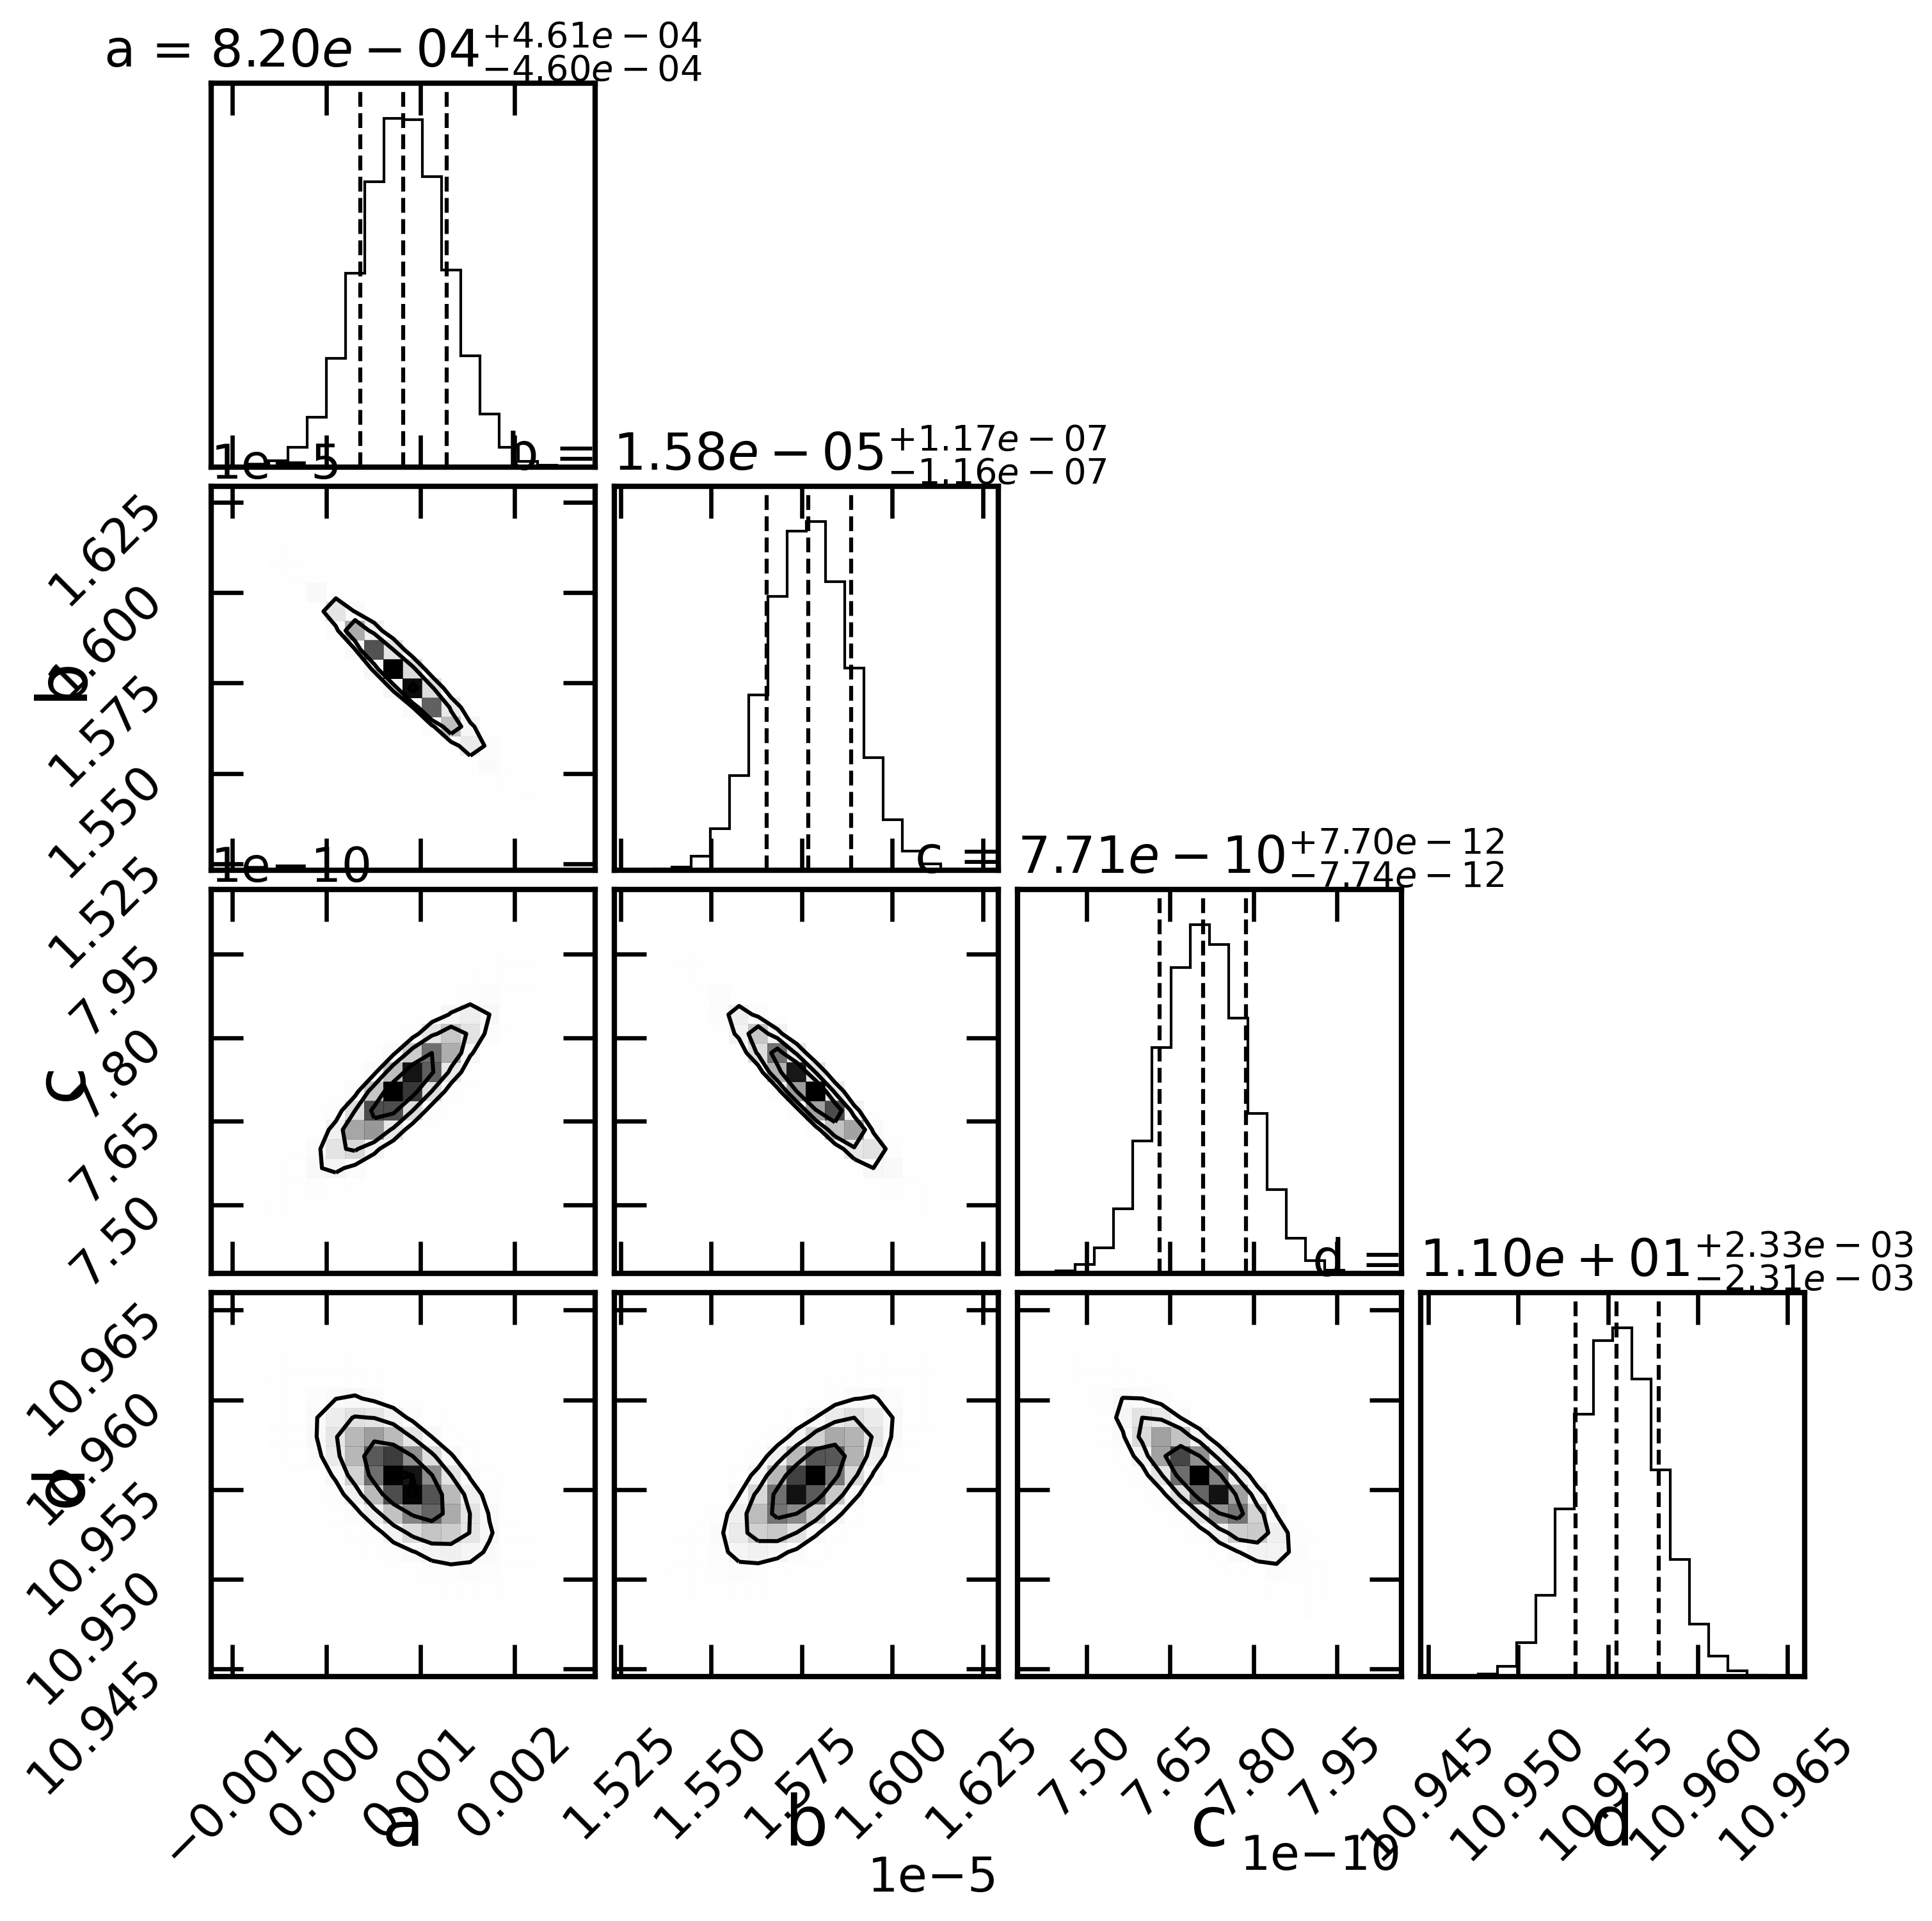

In [201]:
labels = ['a', 'b', 'c', 'd']
fig = corner.corner(
    hm_mcmc_all_samples,
    show_titles=True,
    labels=labels,
    plot_datapoints=False,
    quantiles=[0.16, 0.5, 0.84],
    title_fmt='.2e')
fig.savefig('plots/results/bbrate_fit/hm_cornerplot.png')
fig.savefig('plots/results/bbrate_fit/hm_cornerplot.pdf')

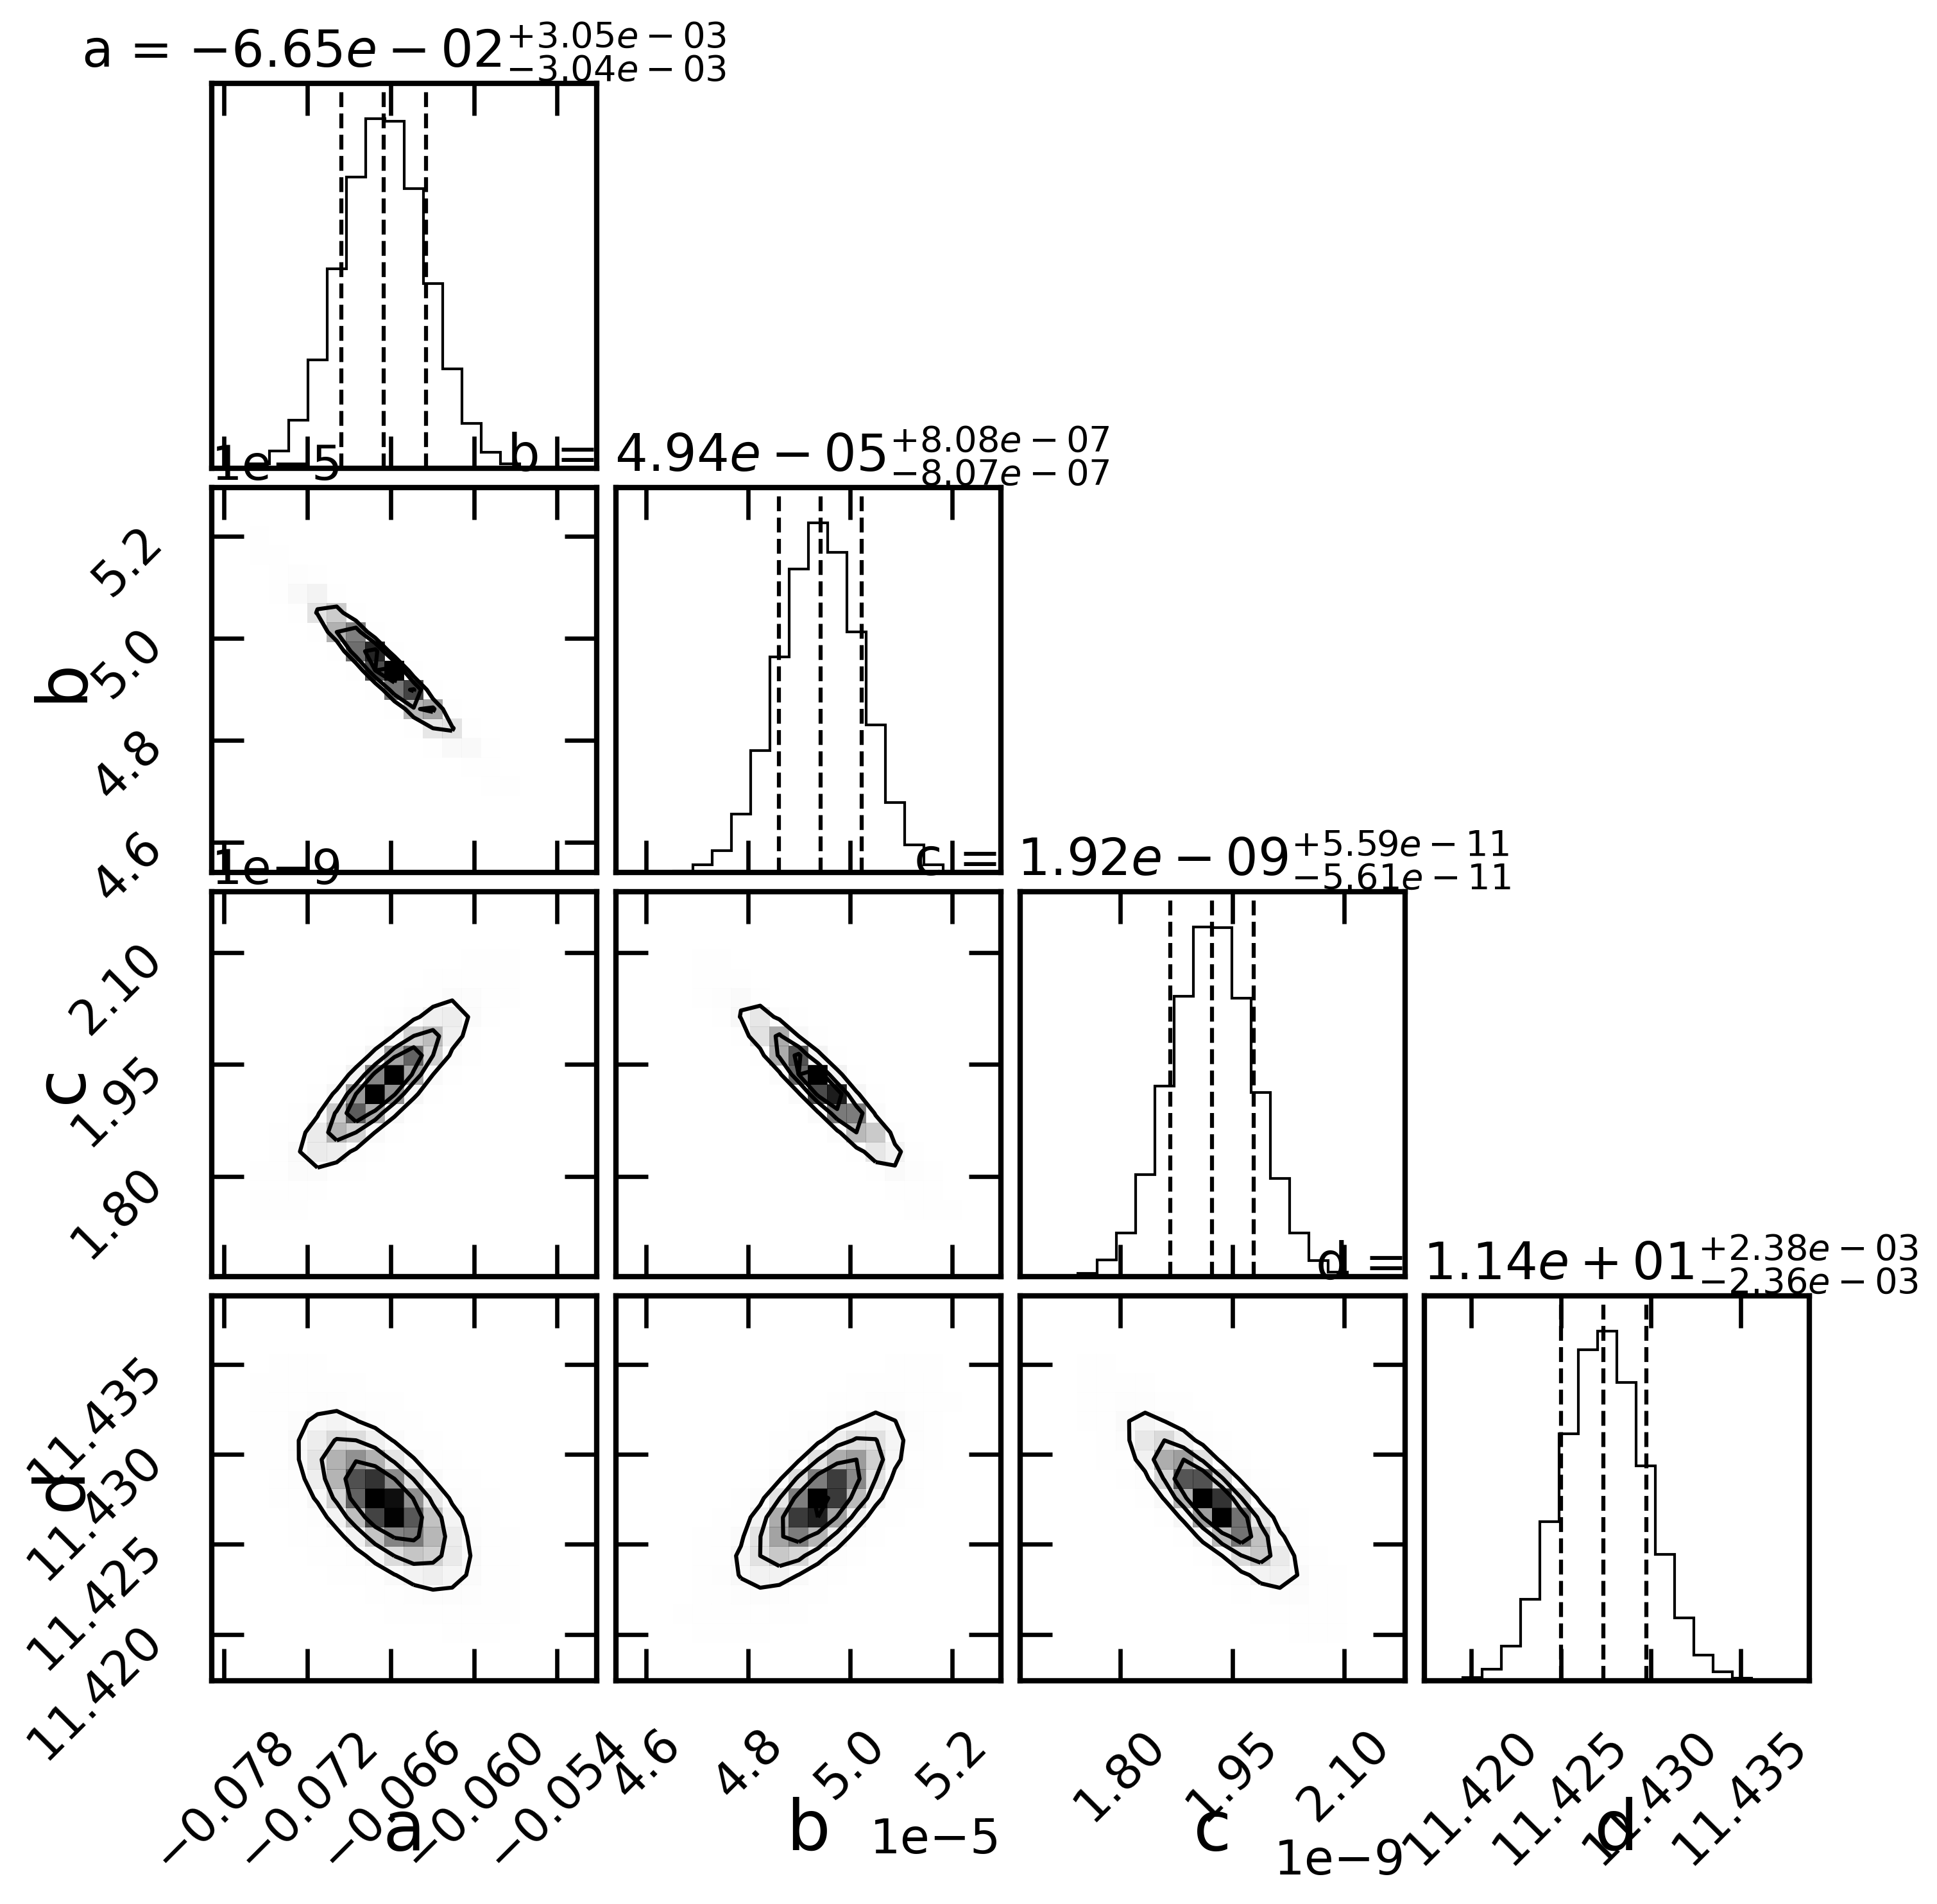

In [202]:
labels = ['a', 'b', 'c', 'd']
fig = corner.corner(
    h2p_mcmc_all_samples,
    show_titles=True,
    labels=labels,
    plot_datapoints=False,
    quantiles=[0.16, 0.5, 0.84],
    title_fmt='.2e')
fig.savefig('plots/results/bbrate_fit/h2p_cornerplot.png')
fig.savefig('plots/results/bbrate_fit/h2p_cornerplot.pdf')

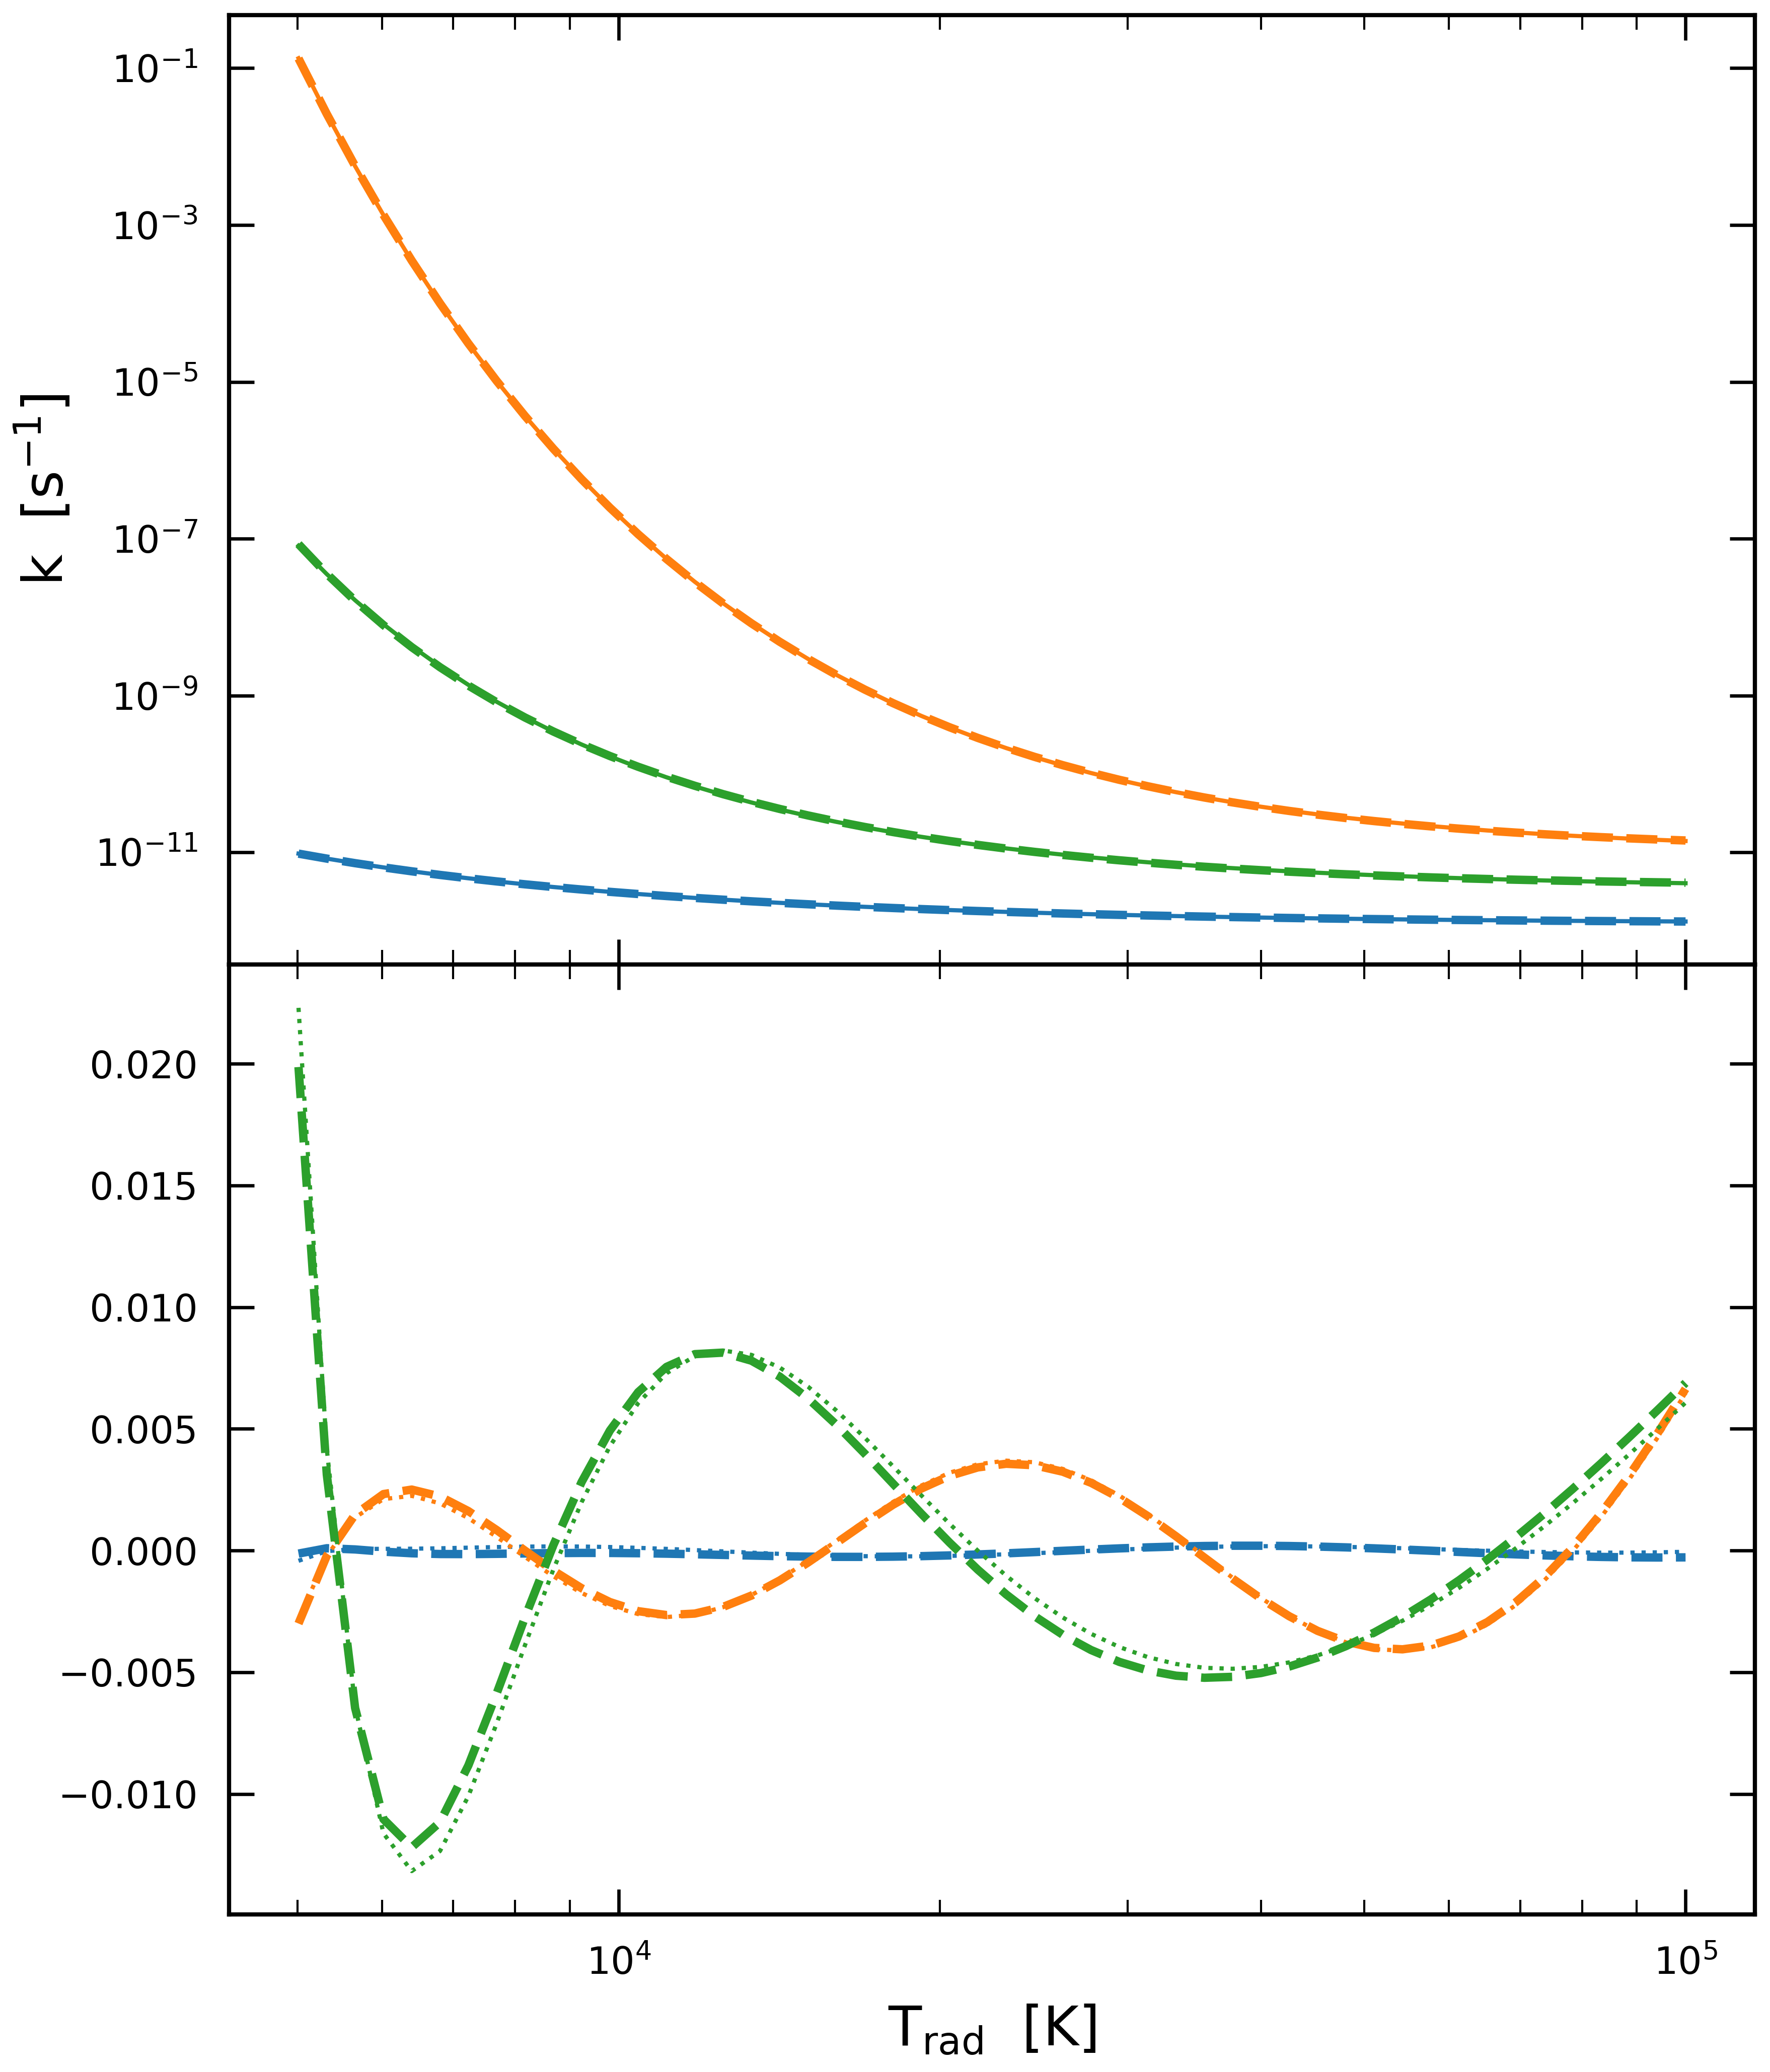

In [203]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(12, 14))
ax = axes[0]
for i, rate in enumerate(['h2', 'hm', 'h2p']):
    ax.plot(
        input_data_for_fit['radtemp'],
        input_data_for_fit[f'{rate}rate'],
        lw=2, ls='-', c=f'C{i}')
#    ax.plot(
#        input_data_for_fit['radtemp'],
#        np.power(10., latif_funct_h2(input_data_for_fit['radtemp'], *fit_params[f'{rate}_guess'])),
#        lw=2, ls=':', c=f'C{i}')
#    ax.plot(
#        input_data_for_fit['radtemp'],
#        np.power(10., latif_funct_h2(input_data_for_fit['radtemp'], *fit_params[f'{rate}_scipy'])),
#        lw=2, ls='-.', c=f'C{i}')
    ax.plot(
        input_data_for_fit['radtemp'],
        np.power(10., latif_funct_h2(input_data_for_fit['radtemp'], *fit_params[f'{rate}_mcmc'])),
        lw=4, ls='--', c=f'C{i}')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'k  [s$^{-1}$]')

ax = axes[1]
for i, rate in enumerate(['h2', 'hm', 'h2p']):
    ax.plot(
        input_data_for_fit['radtemp'],
        latif_funct_h2(input_data_for_fit['radtemp'], *fit_params[f'{rate}_scipy']) - input_data_for_fit[f'log{rate}rate'],
        lw=2, ls=':', c=f'C{i}')
    ax.plot(
        input_data_for_fit['radtemp'],
        latif_funct_h2(input_data_for_fit['radtemp'], *fit_params[f'{rate}_mcmc']) - input_data_for_fit[f'log{rate}rate'],
        lw=4, ls='--', c=f'C{i}')
ax.set_xlabel(r'T$_\mathrm{rad}$  [K]')
plt.tight_layout()
plt.subplots_adjust(hspace=0)


In [204]:
for rate in ['h2', 'hm', 'h2p']:
    print(fit_params[f'{rate}_scipy'])
    print(fit_params[f'{rate}_mcmc'])

[-1.61237218e-01  2.42086225e-04  3.22217577e-09  1.18987554e+01]
[-1.66590646e-01  2.43459320e-04  3.11986004e-09  1.18992706e+01]
[7.69237298e-04 1.57827540e-05 7.69953035e-10 1.09557720e+01]
[8.19506853e-04 1.57687318e-05 7.70926331e-10 1.09554919e+01]
[-6.84664318e-02  4.99511930e-05  1.88589801e-09  1.14287526e+01]
[-6.65030047e-02  4.94127105e-05  1.92313365e-09  1.14273832e+01]


In [158]:
latif_fit_coeff_h2 = np.array([1.1735e-1, 2.4958e-4, 3.4856e-9, 1.1902e1])
latif_fit_coeff_hm = np.array([9.08944e-2, 3.27940e-5, 5.98490e-1, 1.09867e1])
latif_fit_coeff_h2p = np.array([3.83012e6, 5.06440e2, 6.20988e-1, 3.68778e-12])

latif_fit_h2rate = latif_funct_h2(input_data_for_fit['radtemp'], *latif_fit_coeff_h2)
latif_fit_h2rate = np.power(10., latif_fit_h2rate)

latif_fit_hmrate = latif_funct_hm(input_data_for_fit['radtemp'], *latif_fit_coeff_hm)
latif_fit_hmrate = np.power(10., latif_fit_hmrate)

latif_fit_h2prate = latif_funct_h2p(input_data_for_fit['radtemp'], *latif_fit_coeff_h2p)

<ipython-input-13-4716303b8fe1>:19: RuntimeWarning: invalid value encountered in power
  return (-1. * a + b * x)**(-1 / c) + d


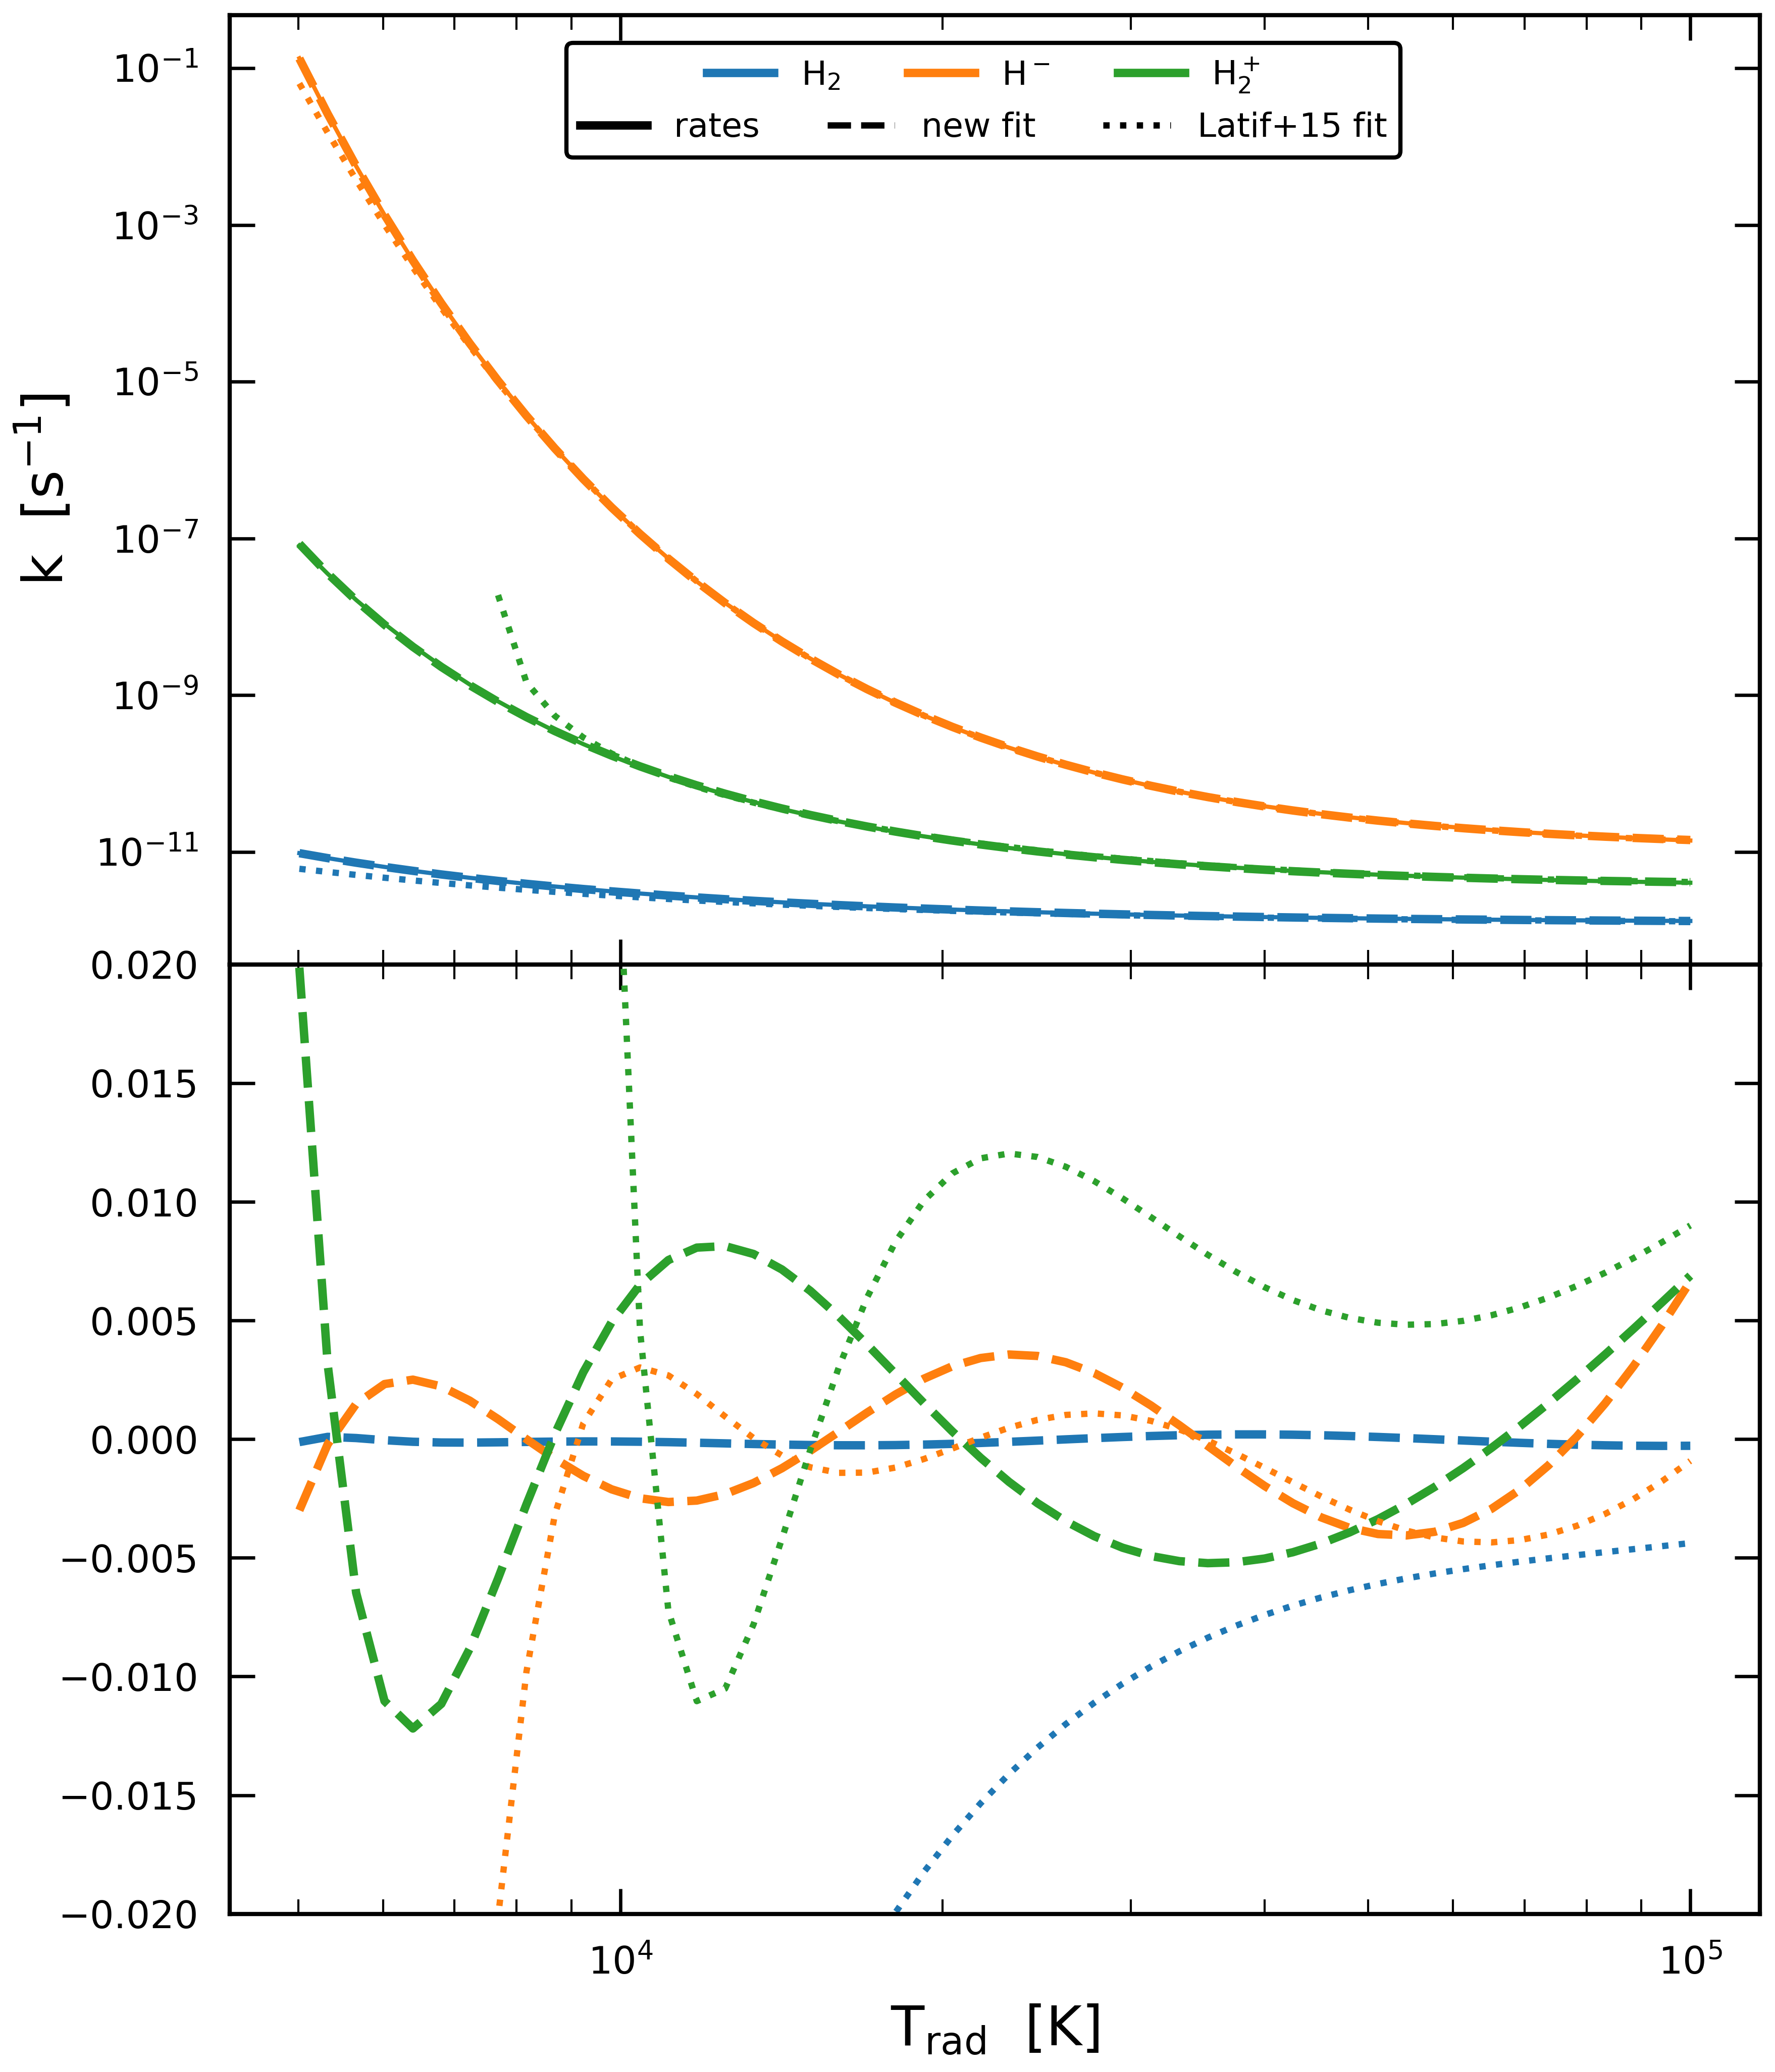

In [205]:
from matplotlib.lines import Line2D
from matplotlib import legend as mlegend

custom_lines1 = [Line2D([0], [0], c='C0', lw=4),
                 Line2D([0], [0], c='C1', lw=4),
                 Line2D([0], [0], c='C2', lw=4)]
custom_lines2 = [Line2D([0], [0], c='k', ls='-', lw=4),
                 Line2D([0], [0], c='k', ls='--',lw=3),
                 Line2D([0], [0], c='k', ls=':', lw=3)]
custom_labels1 = [r'$\mathrm{H}_2$', r'$\mathrm{H}^-$', r'$\mathrm{H}^+_2$']
custom_labels2 = ['rates', 'new fit', 'Latif+15 fit']

fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(12, 14))

ax = axes[0]
for i, rate in enumerate(['h2', 'hm', 'h2p']):
    ax.plot(
        input_data_for_fit['radtemp'],
        input_data_for_fit[f'{rate}rate'],
        lw=2, ls='-', c=f'C{i}')
    ax.plot(
        input_data_for_fit['radtemp'],
        np.power(10., latif_funct_h2(input_data_for_fit['radtemp'], *fit_params[f'{rate}_mcmc'])),
        lw=4, ls='--', c=f'C{i}')
ax.plot(
    input_data_for_fit['radtemp'],
    latif_fit_h2rate,
    lw=3, ls=':', c='C0')
ax.plot(
    input_data_for_fit['radtemp'],
    latif_fit_hmrate,
    lw=3, ls=':', c='C1')
ax.plot(
    input_data_for_fit['radtemp'],
    latif_fit_h2prate,
    lw=3, ls=':', c='C2')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'k  [s$^{-1}$]')
legend1 = ax.legend(custom_lines1, custom_labels1, ncol=3, loc=(0.22, 0.85))
legend2 = mlegend.Legend(ax, custom_lines2, custom_labels2, ncol=3)
legend1._legend_box._children.append(legend2._legend_box._children[1])
legend1.get_frame().set_linewidth(2)

ax = axes[1]
for i, rate in enumerate(['h2', 'hm', 'h2p']):
    ax.plot(
        input_data_for_fit['radtemp'],
        latif_funct_h2(input_data_for_fit['radtemp'], *fit_params[f'{rate}_mcmc']) - input_data_for_fit[f'log{rate}rate'],
        lw=4, ls='--', c=f'C{i}')
ax.plot(
    radiation_temperature_array,
    np.log10(latif_fit_h2rate) - input_data_for_fit['logh2rate'],
    lw=3, ls=':', c='C0')
ax.plot(
    radiation_temperature_array,
    np.log10(latif_fit_hmrate) - input_data_for_fit['loghmrate'],
    lw=3, ls=':', c='C1')
ax.plot(
    radiation_temperature_array,
    np.log10(latif_fit_h2prate) - input_data_for_fit['logh2prate'],
    lw=3, ls=':', c='C2')
ax.set_xlabel(r'T$_\mathrm{rad}$  [K]')
ax.set_ylim(-0.02, 0.02)
plt.tight_layout()
plt.subplots_adjust(hspace=0)


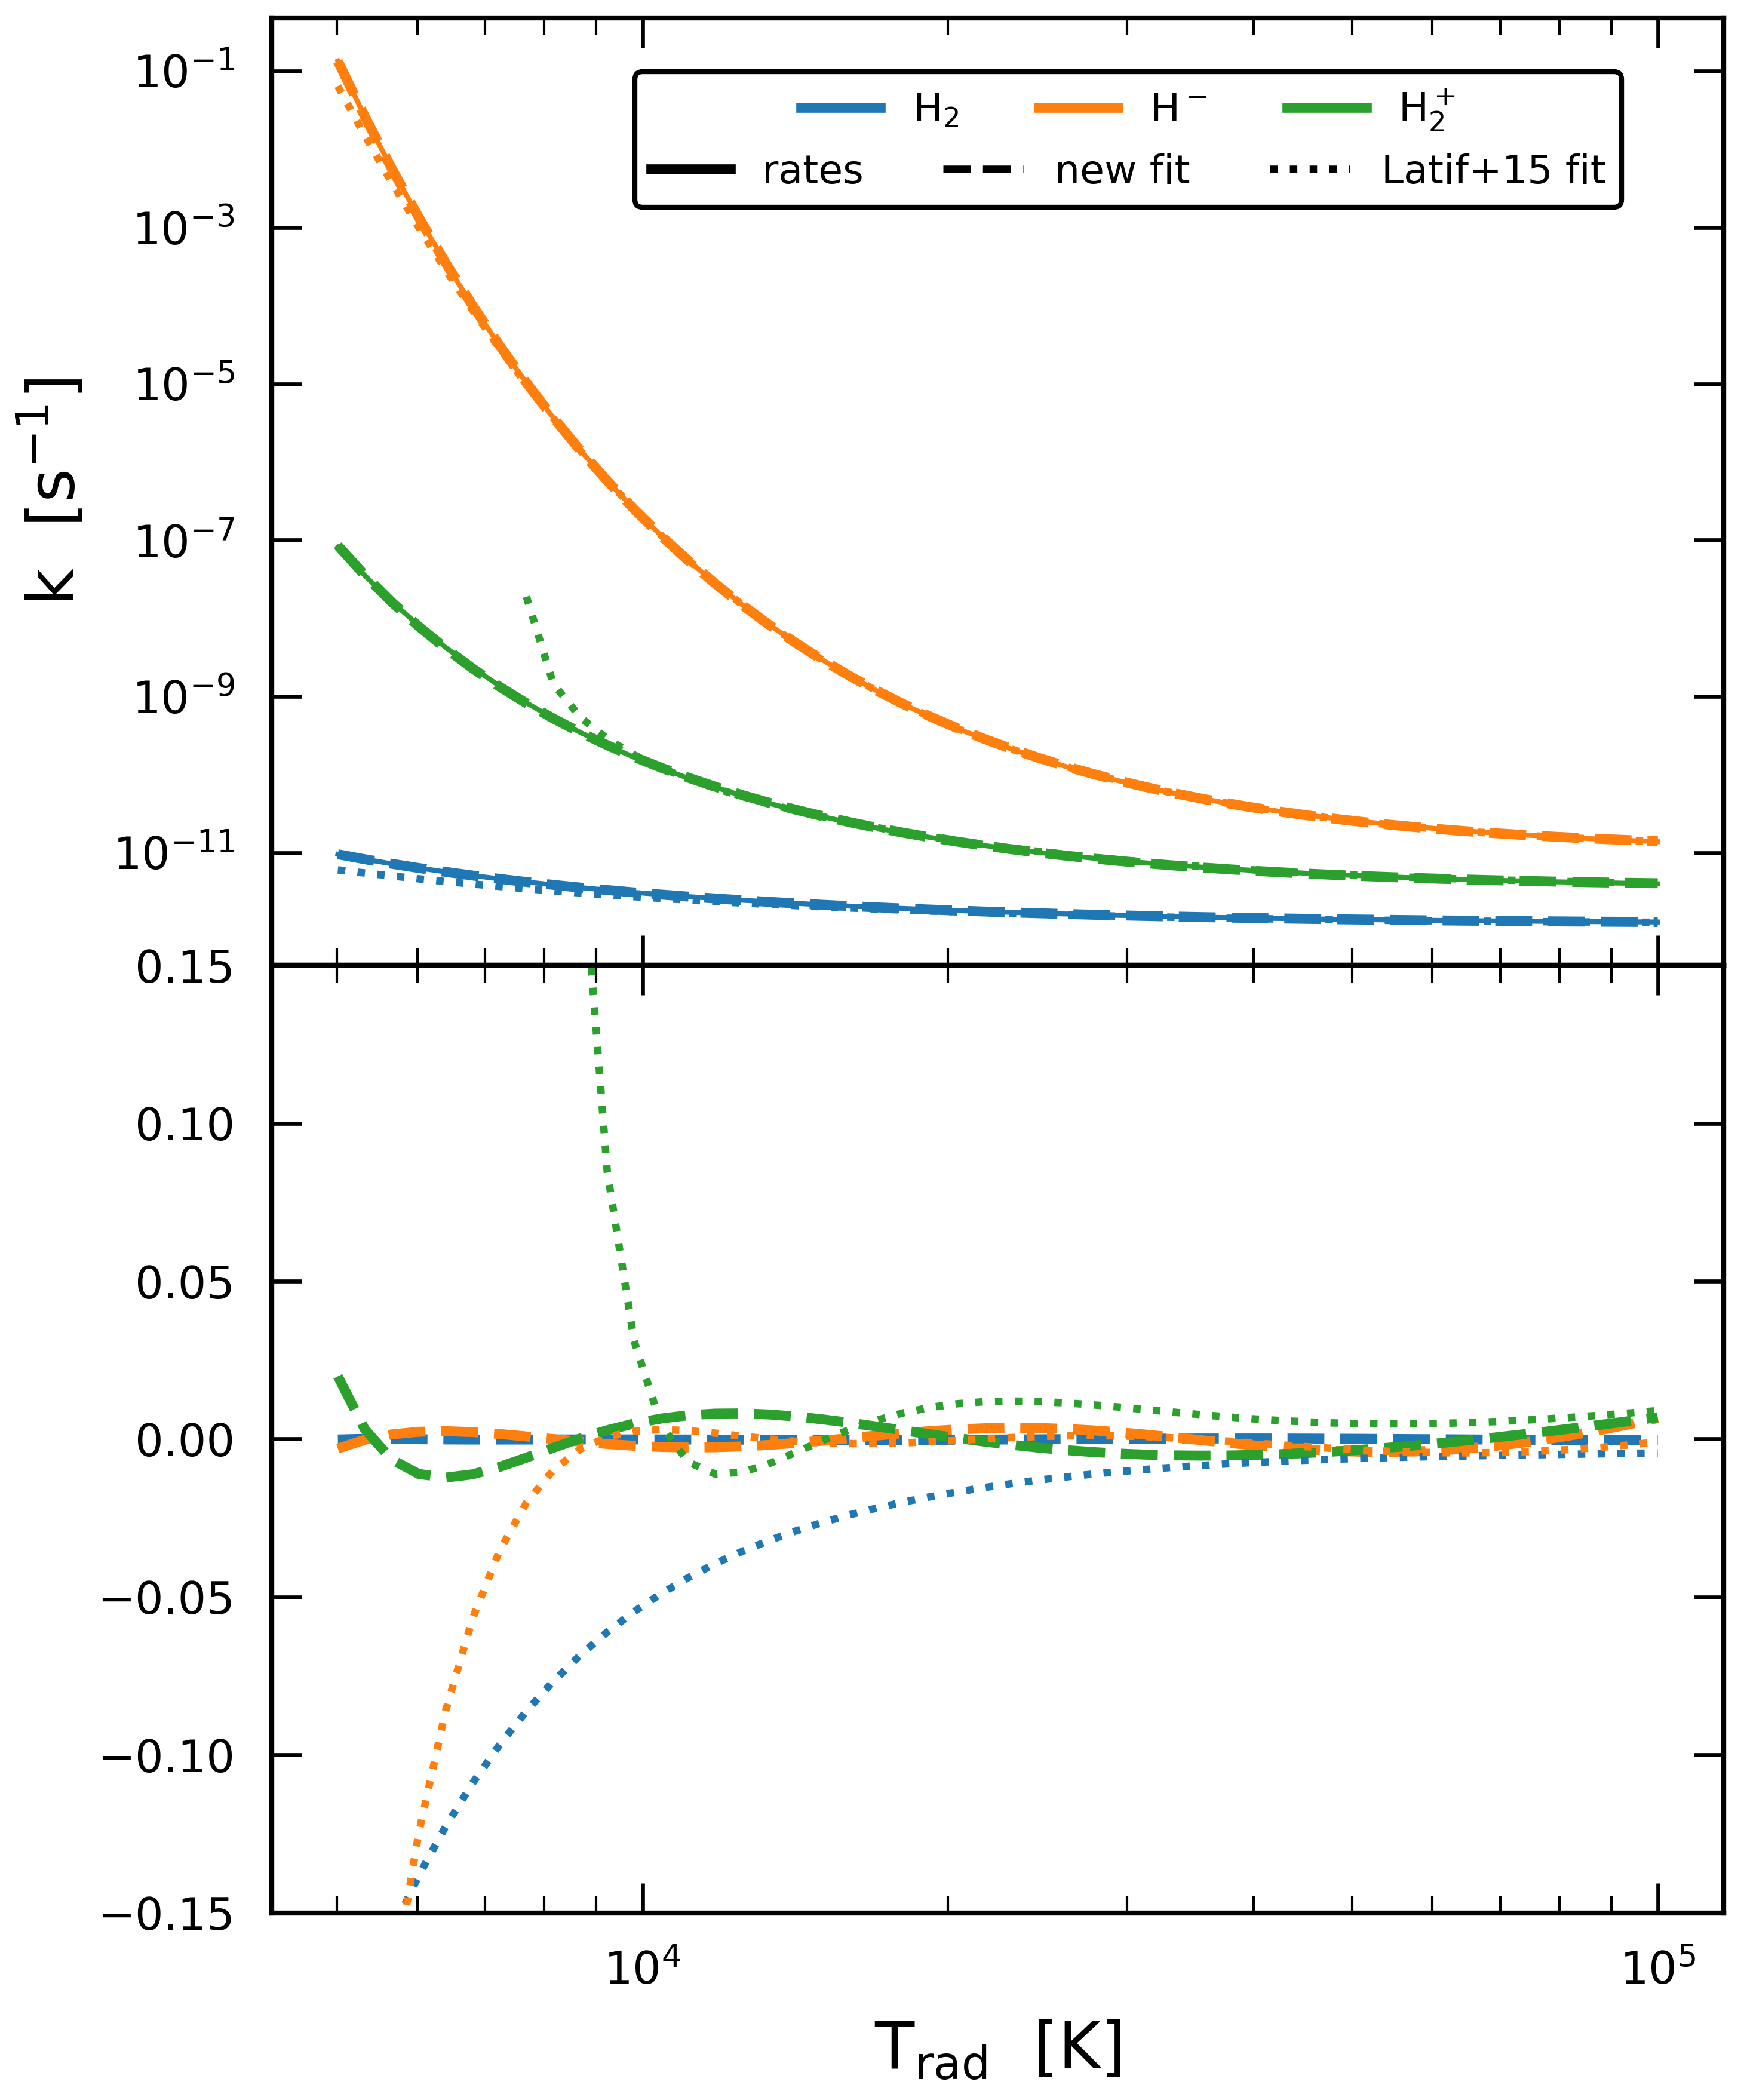

In [206]:
from matplotlib.lines import Line2D
from matplotlib import legend as mlegend

custom_lines1 = [Line2D([0], [0], c='C0', lw=4),
                 Line2D([0], [0], c='C1', lw=4),
                 Line2D([0], [0], c='C2', lw=4)]
custom_lines2 = [Line2D([0], [0], c='k', ls='-', lw=4),
                 Line2D([0], [0], c='k', ls='--',lw=3),
                 Line2D([0], [0], c='k', ls=':', lw=3)]
custom_labels1 = [r'$\mathrm{H}_2$', r'$\mathrm{H}^-$', r'$\mathrm{H}^+_2$']
custom_labels2 = ['rates', 'new fit', 'Latif+15 fit']

fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(10, 12))

ax = axes[0]
for i, rate in enumerate(['h2', 'hm', 'h2p']):
    ax.plot(
        input_data_for_fit['radtemp'],
        input_data_for_fit[f'{rate}rate'],
        lw=2, ls='-', c=f'C{i}')
    ax.plot(
        input_data_for_fit['radtemp'],
        np.power(10., latif_funct_h2(input_data_for_fit['radtemp'], *fit_params[f'{rate}_mcmc'])),
        lw=4, ls='--', c=f'C{i}')
ax.plot(
    input_data_for_fit['radtemp'],
    latif_fit_h2rate,
    lw=3, ls=':', c='C0')
ax.plot(
    input_data_for_fit['radtemp'],
    latif_fit_hmrate,
    lw=3, ls=':', c='C1')
ax.plot(
    input_data_for_fit['radtemp'],
    latif_fit_h2prate,
    lw=3, ls=':', c='C2')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'k  [s$^{-1}$]')
legend1 = ax.legend(custom_lines1, custom_labels1, ncol=3, loc=(0.25, 0.80))
legend2 = mlegend.Legend(ax, custom_lines2, custom_labels2, ncol=3)
legend1._legend_box._children.append(legend2._legend_box._children[1])
legend1.get_frame().set_linewidth(2)

ax = axes[1]
for i, rate in enumerate(['h2', 'hm', 'h2p']):
    ax.plot(
        input_data_for_fit['radtemp'],
        latif_funct_h2(input_data_for_fit['radtemp'], *fit_params[f'{rate}_mcmc']) - input_data_for_fit[f'log{rate}rate'],
        lw=4, ls='--', c=f'C{i}')
ax.plot(
    radiation_temperature_array,
    np.log10(latif_fit_h2rate) - input_data_for_fit['logh2rate'],
    lw=3, ls=':', c='C0')
ax.plot(
    radiation_temperature_array,
    np.log10(latif_fit_hmrate) - input_data_for_fit['loghmrate'],
    lw=3, ls=':', c='C1')
ax.plot(
    radiation_temperature_array,
    np.log10(latif_fit_h2prate) - input_data_for_fit['logh2prate'],
    lw=3, ls=':', c='C2')
ax.set_xlabel(r'T$_\mathrm{rad}$  [K]')
ax.set_ylim(-0.15, 0.15)
plt.tight_layout()
plt.subplots_adjust(hspace=0)
folder_for_saving = os.path.join(os.getcwd(), 'plots', 'results', 'bbrate_fit')
plt.savefig(os.path.join(folder_for_saving, 'latif_comparison.pdf'))
plt.savefig(os.path.join(folder_for_saving, 'latif_comparison.png'))